# Traveled speeds between meals

The Quota for Exercise of Parliamentary Activity says that meal expenses can be reimbursed just for the politician, excluding guests and assistants. Creating a feature with information of "traveled speed" (i.e. too many meals in distant cities, in a short period of time) from last meal can help us detect anomalies compared to other expenses.

Since we don't have in structured data the time of the expense, we want to anylize the group of expenses made in the same day.

In [1]:
import pandas as pd
import numpy as np

reimbursements = pd.read_csv('../data/2016-11-19-reimbursements.xz',
                             dtype={'cnpj_cpf': np.str},
                             low_memory=False)

In [2]:
reimbursements.iloc[0]

year                                                       2009
applicant_id                                               1001
document_id                                             1564212
reimbursement_value_total                                   NaN
total_net_value                                             130
reimbursement_numbers                                      2888
congressperson_name                            DILCEU SPERAFICO
congressperson_id                                         73768
congressperson_document                                     444
term                                                       2015
state                                                        PR
party                                                        PP
term_id                                                      55
subquota_number                                               3
subquota_description                       Fuels and lubricants
subquota_group_id                       

In [3]:
reimbursements = reimbursements[reimbursements['subquota_description'] == 'Congressperson meal']
reimbursements.shape

(191724, 31)

In [4]:
reimbursements['issue_date'] = pd.to_datetime(reimbursements['issue_date'], errors='coerce')
reimbursements.sort_values('issue_date', inplace=True)

In [5]:
companies = pd.read_csv('../data/2016-09-03-companies.xz', low_memory=False)
companies.shape

(60047, 228)

In [6]:
companies.iloc[0]

situation_date                                                     03/11/2005
type                                                                   MATRIZ
name                             COMPANHIA DE AGUAS E ESGOTOS DE RORAIMA CAER
phone                                                          (95) 3626-5165
situation                                                               ATIVA
neighborhood                                                        SAO PEDRO
address                                                        R MELVIN JONES
number                                                                    219
zip_code                                                           69.306-610
city                                                                BOA VISTA
state                                                                      RR
opening                                                            21/11/1969
legal_entity                              203-8 - SOCIEDADE DE E

In [7]:
companies['cnpj'] = companies['cnpj'].str.replace(r'[\.\/\-]', '')

In [8]:
dataset = pd.merge(reimbursements, companies, left_on='cnpj_cpf', right_on='cnpj')
dataset.shape

(176005, 259)

In [9]:
dataset.iloc[0]

year                                                               2011
applicant_id                                                       2303
document_id                                                     2003049
reimbursement_value_total                                           NaN
total_net_value                                                      80
reimbursement_numbers                                              3554
congressperson_name                                       RONALDO ZULKE
congressperson_id                                                160594
congressperson_document                                             515
term                                                               2011
state_x                                                              RS
party                                                                PT
term_id                                                              54
subquota_number                                                 

Remove party leaderships from the dataset before calculating the ranking.

In [10]:
dataset = dataset[dataset['congressperson_id'].notnull()]
dataset.shape

(175071, 259)

And also remove companies mistakenly geolocated outside of Brazil.

In [11]:
is_in_brazil = '(-73.992222 < longitude < -34.7916667) & (-33.742222 < latitude < 5.2722222)'
dataset = dataset.query(is_in_brazil)
dataset.shape

(168568, 259)

In [12]:
# keys = ['applicant_id', 'issue_date']
keys = ['congressperson_name', 'issue_date']
aggregation = dataset.groupby(keys)['total_net_value']. \
    agg({'sum': np.sum, 'expenses': len, 'mean': np.mean})

In [13]:
aggregation['expenses'] = aggregation['expenses'].astype(np.int)

In [14]:
aggregation.sort_values(['expenses', 'sum'], ascending=[False, False]).head(10)

sum       mean  expenses
congressperson_name issue_date                             
CELSO MALDANER      2011-09-05  750.28  57.713846        13
SANDRA ROSADO       2012-01-12  333.40  27.783333        12
                    2012-01-17  287.43  23.952500        12
                    2012-01-06  281.75  23.479167        12
LÉO VIVAS           2010-08-31  630.00  57.272727        11
SANDRA ROSADO       2012-01-11  541.56  49.232727        11
PAULO WAGNER        2011-07-21  537.66  48.878182        11
SANDRA ROSADO       2015-01-07  396.60  36.054545        11
                    2012-01-15  295.58  26.870909        11
FRANCISCO DE ASSIS  2014-11-18  565.99  56.599000        10

In [15]:
len(aggregation[aggregation['expenses'] > 7])

32

In [16]:
keys = ['congressperson_name', 'issue_date']
cities = dataset.groupby(keys)['city']. \
    agg({'city': lambda x: len(set(x)),
         'city_list': lambda x: ','.join(set(x))}
       ).sort_values('city', ascending=False)

In [17]:
cities.head()

,,city_list,city
congressperson_name,issue_date,,
TAKAYAMA,2014-06-25,"GUARAPUAVA,LARANJEIRAS DO SUL,FERNANDES PINHEI...",6
ZECA DIRCEU,2012-02-14,"PAICANDU,MARINGA,GUARULHOS,PARANAVAI,BRASILIA",5
RICARDO IZAR,2014-04-26,"BAURU,PRAIA GRANDE,LINS,SAO PAULO,BOITUVA",5
PAULO FERREIRA,2013-02-08,"EMBU DAS ARTES,IGARAPAVA,LIMEIRA,IPAMERI,BRASILIA",5
MARGARIDA SALOMÃO,2014-12-02,"JUIZ DE FORA,BARBACENA,BELO HORIZONTE,RIO DE J...",5


In [18]:
cities[cities['city'] >= 4].shape

(127, 2)

Would be helpful for our analysis to have a new column containing the traveled distance in this given day.

## New traveled distance column for each day/congressperson

In [19]:
from geopy.distance import vincenty as distance
from IPython.display import display

x = dataset.iloc[0]
display(x[['cnpj', 'city', 'state_y']])
distance(x[['latitude', 'longitude']],
         x[['latitude', 'longitude']])

cnpj       72614977000290
city             BRASILIA
state_y                DF
Name: 0, dtype: object

Distance(0.0)

In [20]:
dataset.shape

(168568, 259)

In [21]:
dataset[['latitude', 'longitude']].dropna().shape

(168568, 2)

In [22]:
from itertools import tee

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def calculate_distances(x):
    coordinate_list = x[['latitude', 'longitude']].values
    distance_list = [distance(*coordinates_pair).km
                     for coordinates_pair in pairwise(coordinate_list)]
    return np.nansum(distance_list)

distances = dataset.groupby(keys).apply(calculate_distances)

This way works, but the order of the visited cities is important. We need to find a way of calculate in the proper order or be fair in all calculations.

In [23]:
distances = distances.reset_index() \
    .rename(columns={0: 'distance_traveled'}) \
    .sort_values('distance_traveled', ascending=False)
distances.head()

,congressperson_name,issue_date,distance_traveled
112369,SANDRA ROSADO,2012-09-04,6969.643860
112201,SANDRA ROSADO,2012-01-12,6965.526389
112210,SANDRA ROSADO,2012-01-23,6833.928798
112221,SANDRA ROSADO,2012-02-08,5333.782132
112295,SANDRA ROSADO,2012-06-12,5309.248049


Now we are not ordering the list of cities, just calculating the distance between them in the order they are in the dataset. Since we don't have the time of the expenses to know their real order, one approach is to consider the shortest path between in the cities visited in the day by the congressperson.

In [24]:
import networkx as nx

G = nx.Graph()

In [25]:
G=nx.path_graph(5)
G

In [26]:
path=nx.all_pairs_shortest_path(G)
path

{0: {0: [0], 1: [0, 1], 2: [0, 1, 2], 3: [0, 1, 2, 3], 4: [0, 1, 2, 3, 4]},
 1: {0: [1, 0], 1: [1], 2: [1, 2], 3: [1, 2, 3], 4: [1, 2, 3, 4]},
 2: {0: [2, 1, 0], 1: [2, 1], 2: [2], 3: [2, 3], 4: [2, 3, 4]},
 3: {0: [3, 2, 1, 0], 1: [3, 2, 1], 2: [3, 2], 3: [3], 4: [3, 4]},
 4: {0: [4, 3, 2, 1, 0], 1: [4, 3, 2, 1], 2: [4, 3, 2], 3: [4, 3], 4: [4]}}

In [27]:
path[0][4]

[0, 1, 2, 3, 4]

In [28]:
random_congressperson_day = cities[cities['city'] == 3].sample(random_state=0).reset_index().iloc[0]
matching_keys = ['congressperson_name', 'issue_date']
matches = \
    (dataset['congressperson_name'] == random_congressperson_day['congressperson_name']) & \
    (dataset['issue_date'] == random_congressperson_day['issue_date'])
expenses_for_graph = dataset[matches]
expenses_for_graph

,year,applicant_id,document_id,reimbursement_value_total,total_net_value,reimbursement_numbers,congressperson_name,congressperson_id,congressperson_document,term,...,secondary_activity_97_code,secondary_activity_98,secondary_activity_98_code,secondary_activity_99,secondary_activity_99_code,secondary_activity_9_code,latitude,longitude,latitude.1,longitude.1
69171,2013,2816,5197567,NaN,22.2,4382,NILMÁRIO MIRANDA,74751.0,542.0,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-15.784347,-47.913276,-15.784347,-47.913276
112211,2013,2816,5202209,NaN,50.0,4385,NILMÁRIO MIRANDA,74751.0,542.0,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-18.365815,-44.458726,-18.365815,-44.458726
135219,2013,2816,5202073,NaN,55.9,4402,NILMÁRIO MIRANDA,74751.0,542.0,2015.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-16.723344,-43.871767,-16.723344,-43.871767


In [29]:
def city_and_state(row):
    return '{} - {}'.format(row['city'], row['state_y'])

expenses_for_graph['city_state'] = expenses_for_graph.apply(city_and_state, axis=1)
expenses_for_graph['city_state']

/Users/irio/anaconda3/envs/serenata_de_amor/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


69171          BRASILIA - DF
112211          CORINTO - MG
135219    MONTES CLAROS - MG
Name: city_state, dtype: object

In [30]:
lat_longs = expenses_for_graph[['city_state', 'latitude', 'longitude']].values
# np.apply_along_axis(lambda x: (x[0], x[1]), axis=1, arr=lat_longs)

* Create a node for each of the cities.
* Connect each city with every other (making it a "complete graph").
* Give weight to each of the edges, which should correspond to the distance between the cities.
* Create a new node (artificial origin/destination for the Traveling Salesman).
* Connect this new node with every other node, with weight equal to zero.
* Run the Traveling Salesman algorithm starting from the artificial node.

<!-- * Run the Hamiltonian path algorithm. -->

In [31]:
from itertools import combinations

list(combinations(lat_longs.tolist(), 2))

[(['BRASILIA - DF', -15.7843468, -47.9132763],
  ['CORINTO - MG', -18.3658152, -44.4587258]),
 (['BRASILIA - DF', -15.7843468, -47.9132763],
  ['MONTES CLAROS - MG', -16.723344400000002, -43.8717668]),
 (['CORINTO - MG', -18.3658152, -44.4587258],
  ['MONTES CLAROS - MG', -16.723344400000002, -43.8717668])]

In [32]:
def create_node(row):
    print(row[0], row[1], row[2])
    cities_graph.add_node(row[0], pos=(row[1], row[2]))
    return 42

cities_graph = nx.Graph()
np.apply_along_axis(create_node, axis=1, arr=lat_longs)

edges = list(combinations(lat_longs.tolist(), 2))
for edge in edges:
    weight = distance(edge[0][1:], edge[1][1:]).km
    print(edge[0][0], edge[1][0], weight)
    cities_graph.add_edge(edge[0][0], edge[1][0], weight=weight)

BRASILIA - DF -15.7843468 -47.9132763
CORINTO - MG -18.3658152 -44.4587258
MONTES CLAROS - MG -16.723344400000002 -43.8717668
BRASILIA - DF CORINTO - MG 465.6183735694923
BRASILIA - DF MONTES CLAROS - MG 444.33789522900355
CORINTO - MG MONTES CLAROS - MG 192.16579440591534


In [33]:
# cities_graph.add_node('starting_point')
# new_edges = [('starting_point', node) for node in cities_graph.nodes()]
# cities_graph.add_edges_from(new_edges, weight=0)

In [34]:
cities_graph.nodes()

['BRASILIA - DF', 'MONTES CLAROS - MG', 'CORINTO - MG']

In [35]:
cities_graph.edges()

[('BRASILIA - DF', 'CORINTO - MG'),
 ('BRASILIA - DF', 'MONTES CLAROS - MG'),
 ('MONTES CLAROS - MG', 'CORINTO - MG')]

1. Acreditamos no Gist.
2. Revisamos o Gist.
3. Simplesmente esquecemos "distância mínima" e somamos todas as distâncias do complete graph.

In [36]:
# Boworred from https://gist.github.com/mikkelam/ab7966e7ab1c441f947b
# Should we believe this algorithm is well implemented?
# Now is not the best way to learn how to do it ourselves...

def hamilton(G):
    F = [(G,[G.nodes()[0]])]
    n = G.number_of_nodes()
    while F:
        graph,path = F.pop()
        confs = []
        for node in graph.neighbors(path[-1]):
            conf_p = path[:]
            conf_p.append(node)
            conf_g = nx.Graph(graph)
            conf_g.remove_node(path[-1])
            confs.append((conf_g,conf_p))
        for g,p in confs:
            if len(p)==n:
                return p
            else:
                F.append((g,p))
    return None

hamilton(cities_graph)

['BRASILIA - DF', 'MONTES CLAROS - MG', 'CORINTO - MG']

Calculating the minimum distance traveled each day is not so necessary, since we just need a number to say how far the visited cities are from each other. Summing the distances between all of their combinations is good enough.

In [37]:
def calculate_sum_distances(x):
    coordinate_list = x[['latitude', 'longitude']].values
    edges = list(combinations(coordinate_list, 2))
    return np.sum([distance(edge[0][1:], edge[1][1:]).km for edge in edges])

distances = dataset.groupby(keys).apply(calculate_sum_distances)

In [38]:
distances = distances.reset_index() \
    .rename(columns={0: 'distance_traveled'}) \
    .sort_values('distance_traveled', ascending=False)
distances.head()

,congressperson_name,issue_date,distance_traveled
112206,SANDRA ROSADO,2012-01-17,37969.076510
112200,SANDRA ROSADO,2012-01-11,30579.442632
112201,SANDRA ROSADO,2012-01-12,27617.903746
112196,SANDRA ROSADO,2012-01-06,23571.629213
112204,SANDRA ROSADO,2012-01-15,21144.918842


In [39]:
cities.reset_index()

,congressperson_name,issue_date,city_list,city
0,TAKAYAMA,2014-06-25,"GUARAPUAVA,LARANJEIRAS DO SUL,FERNANDES PINHEI...",6
1,ZECA DIRCEU,2012-02-14,"PAICANDU,MARINGA,GUARULHOS,PARANAVAI,BRASILIA",5
2,RICARDO IZAR,2014-04-26,"BAURU,PRAIA GRANDE,LINS,SAO PAULO,BOITUVA",5
3,PAULO FERREIRA,2013-02-08,"EMBU DAS ARTES,IGARAPAVA,LIMEIRA,IPAMERI,BRASILIA",5
4,MARGARIDA SALOMÃO,2014-12-02,"JUIZ DE FORA,BARBACENA,BELO HORIZONTE,RIO DE J...",5
5,ZECA DIRCEU,2015-04-09,"SAO JOSE DOS PINHAIS,JANIOPOLIS,CURITIBA,LUIZI...",5
6,GERALDO THADEU,2013-08-15,"JAGUARIUNA,SAO PAULO,CATALAO,MOGI MIRIM,BRASILIA",5
7,ZECA DIRCEU,2014-12-18,"PAICANDU,CURITIBA,SAO JOSE DOS PINHAIS,CAMPO M...",5
8,ABELARDO LUPION,2011-09-12,"JANDAIA DO SUL,UBERLANDIA,ARAPOTI,IMBAU,BADY B...",5
9,VANDERLEI MACRIS,2013-04-24,"EMBU DAS ARTES,AMERICANA,SAO CAETANO DO SUL,SA...",5


In [40]:
aggregation = pd.merge(aggregation.reset_index(), cities.reset_index())

In [41]:
dataset_with_distances = \
    pd.merge(aggregation,
             distances,
             left_on=keys,
             right_on=keys)
dataset_with_distances.sort_values(['distance_traveled', 'expenses'], ascending=[False, False]).head(10)

,congressperson_name,issue_date,sum,mean,expenses,city_list,city,distance_traveled
112206,SANDRA ROSADO,2012-01-17,287.43,23.952500,12,"FORTALEZA,BRASILIA,MOSSORO",3,37969.076510
112200,SANDRA ROSADO,2012-01-11,541.56,49.232727,11,"NATAL,MOSSORO,BRASILIA",3,30579.442632
112201,SANDRA ROSADO,2012-01-12,333.40,27.783333,12,"FORTALEZA,NATAL,MOSSORO,BRASILIA",4,27617.903746
112196,SANDRA ROSADO,2012-01-06,281.75,23.479167,12,"MOSSORO,BRASILIA",2,23571.629213
112204,SANDRA ROSADO,2012-01-15,295.58,26.870909,11,"MOSSORO,BRASILIA",2,21144.918842
112205,SANDRA ROSADO,2012-01-16,182.14,22.767500,8,"MOSSORO,BRASILIA",2,14072.247943
112210,SANDRA ROSADO,2012-01-23,139.42,19.917143,7,"NATAL,MOSSORO,BRASILIA",3,13185.187380
112198,SANDRA ROSADO,2012-01-09,340.18,34.018000,10,"NATAL,BRASILIA,MOSSORO",3,12717.700035
112248,SANDRA ROSADO,2012-03-28,225.73,37.621667,6,"NATAL,BRASILIA",2,11324.130379
112221,SANDRA ROSADO,2012-02-08,309.46,51.576667,6,"NATAL,BRASILIA",2,11320.374327


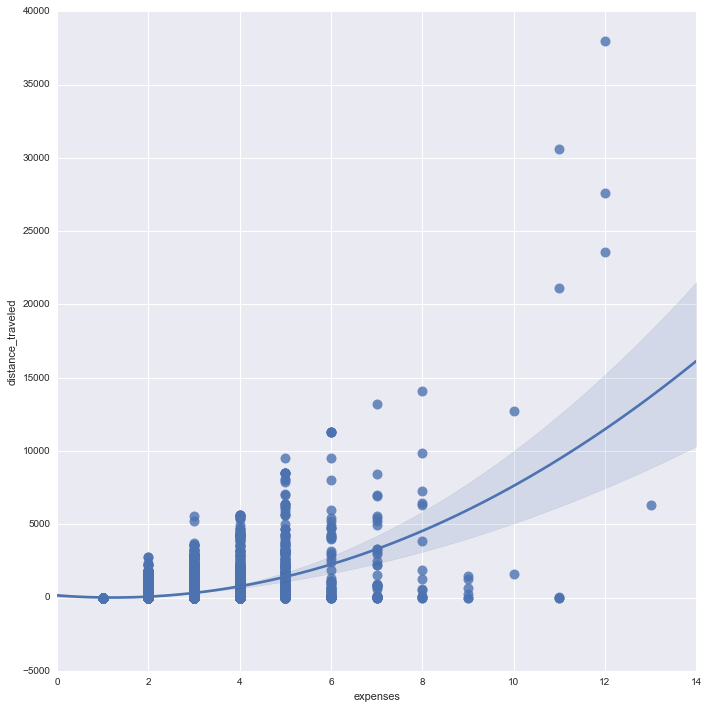

In [42]:
%matplotlib inline
import seaborn as sns

sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances,
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10,
           order=2)

In [43]:
dataset_with_distances.describe()

,sum,mean,expenses,city,distance_traveled
count,130675.000000,130675.000000,130675.000000,130675.000000,130675.000000
mean,82.658007,66.411733,1.289979,1.084745,40.001456
std,95.133361,79.008626,0.632451,0.312260,320.772729
min,0.010000,0.010000,1.000000,1.000000,0.000000
25%,33.300000,29.400000,1.000000,1.000000,0.000000
50%,57.900000,49.510000,1.000000,1.000000,0.000000
75%,106.150000,86.900000,1.000000,1.000000,0.000000
max,6010.000000,5852.000000,13.000000,6.000000,37969.076510


In [44]:
dataset_with_distances[dataset_with_distances['expenses'] > 4].shape

(490, 8)

In [45]:
expenses_ceiling = dataset_with_distances['expenses'].mean() + \
    (3 * dataset_with_distances['expenses'].std())
expenses_ceiling

3.1873315296945344

In [46]:
distance_traveled_ceiling = dataset_with_distances['distance_traveled'].mean() + \
    (3 * dataset_with_distances['distance_traveled'].std())
distance_traveled_ceiling

1002.3196415922741

In [47]:
is_anomaly = (dataset_with_distances['expenses'] > expenses_ceiling) & \
    (dataset_with_distances['distance_traveled'] > distance_traveled_ceiling)
dataset_with_distances[is_anomaly].shape

(471, 8)

In [48]:
dataset_with_distances.loc[is_anomaly].sum()

sum                  9.688267e+04
mean                 2.078132e+04
expenses             2.218000e+03
city                 1.224000e+03
distance_traveled    1.470252e+06
dtype: float64

In [49]:
dataset_with_distances.loc[is_anomaly, 'mean'].mean()

44.121700380770442

In [50]:
len(dataset_with_distances.loc[is_anomaly]) / len(dataset_with_distances)

0.003604361966711307

In [51]:
dataset_with_distances[is_anomaly] \
    .groupby('congressperson_name')['expenses'].count().reset_index() \
    .rename(columns={'expenses': 'abnormal_days'}) \
    .sort_values('abnormal_days', ascending=False) \
    .head(10)

,congressperson_name,abnormal_days
20,DR. ADILSON SOARES,106
71,SANDRA ROSADO,58
31,FRANCISCO FLORIANO,39
80,ZECA DIRCEU,36
66,RENATO MOLLING,34
30,FRANCISCO DE ASSIS,24
74,TAKAYAMA,13
39,JORGE SOLLA,10
76,VANDERLEI MACRIS,10
34,GERALDO THADEU,8


In [52]:
dataset_with_distances['3_stds_anomaly'] = is_anomaly

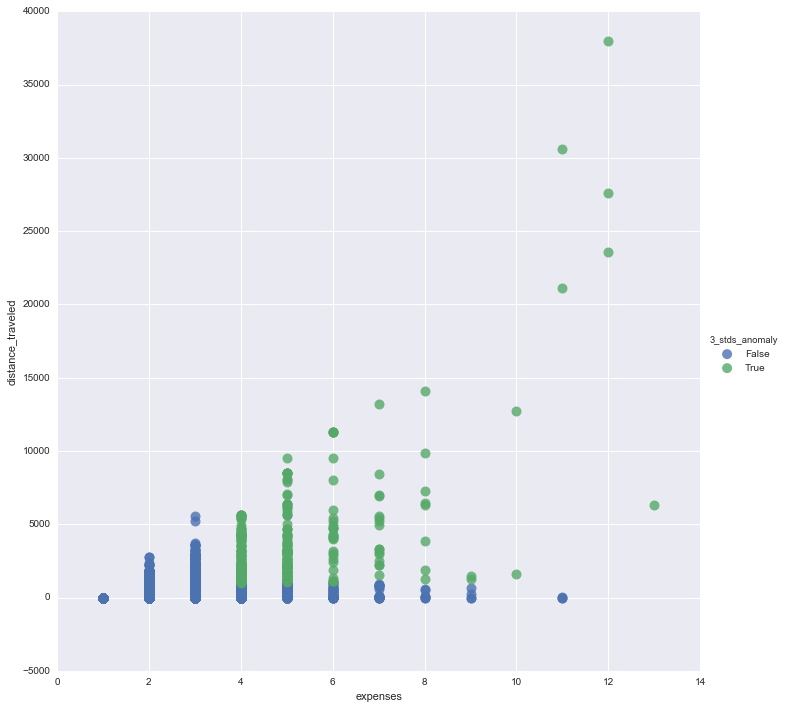

In [53]:
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances,
           fit_reg=False,
           hue='3_stds_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

In [54]:
expenses_ceiling = dataset_with_distances['expenses'].mean() + \
    (5 * dataset_with_distances['expenses'].std())
distance_traveled_ceiling = dataset_with_distances['distance_traveled'].mean() + \
    (5 * dataset_with_distances['distance_traveled'].std())
is_anomaly = (dataset_with_distances['expenses'] > expenses_ceiling) & \
    (dataset_with_distances['distance_traveled'] > distance_traveled_ceiling)
dataset_with_distances[is_anomaly].shape

(164, 9)

In [55]:
expenses_ceiling, distance_traveled_ceiling

(4.4522332458750498, 1643.8650987896879)

In [56]:
dataset_with_distances['5_stds_anomaly'] = is_anomaly

In [57]:
len(dataset_with_distances.loc[is_anomaly]) / len(dataset_with_distances)

0.001255022001147886

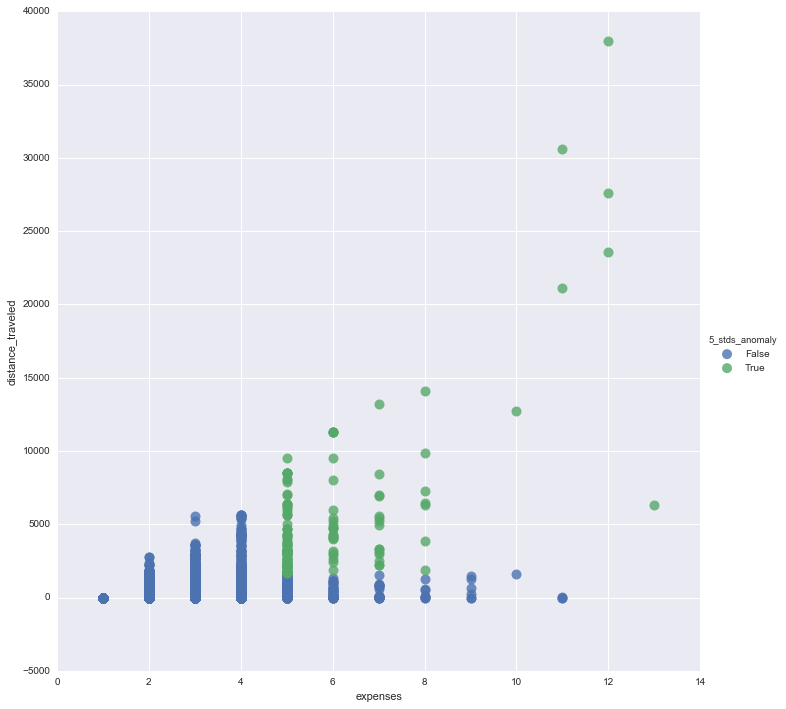

In [58]:
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances,
           fit_reg=False,
           hue='5_stds_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

In [59]:
dataset_with_distances[is_anomaly] \
    .groupby('congressperson_name')['expenses'].count().reset_index() \
    .rename(columns={'expenses': 'abnormal_days'}) \
    .sort_values('abnormal_days', ascending=False) \
    .head(10)

,congressperson_name,abnormal_days
10,DR. ADILSON SOARES,41
31,SANDRA ROSADO,30
35,ZECA DIRCEU,14
15,FRANCISCO DE ASSIS,13
16,FRANCISCO FLORIANO,12
28,RENATO MOLLING,10
18,JORGE SOLLA,6
32,TAKAYAMA,4
25,PAULO WAGNER,3
2,AELTON FREITAS,2


# Outlier detection using IsolationForest algorithm

If we get similar results to this simple method, we expect to find the same congressperon, but not the same days. If we find the same days, our approach is not good enough compared to the simples method because we already that in the previous section we did not considered the combination of features but just their values compared to the distribuition of each feature (column).
We expect the same congrespeople because the previous results shows that those person are travelling a lot more compared to the other congresspeople. For instance, Dr. Adilson Soares appears with 106 abnormal days more then twice than the second in the ranking, Sandra Rosado. Thus, would be expected to see him in the top ranking of congresspeople with abnormal meal expenses.

## Histogram of expenses

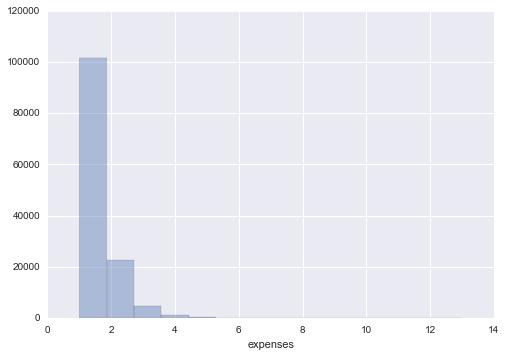

In [60]:
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

sns.distplot(dataset_with_distances['expenses'],
             bins=14,
             kde=False)

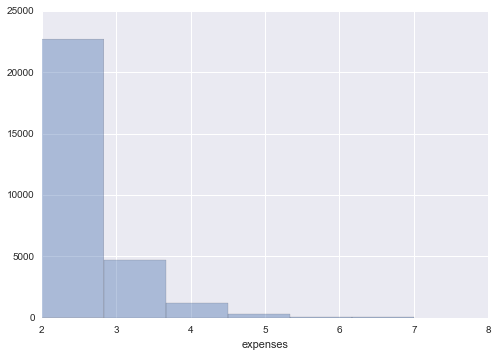

In [61]:
sns.distplot(dataset_with_distances.query('1 < expenses < 8')['expenses'],
    bins=6,
    kde=False
)

## Histogram of distance traveled

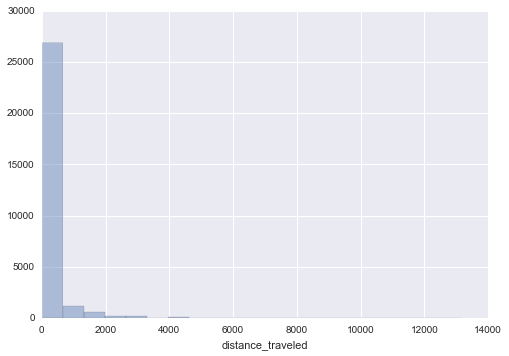

In [62]:
query = '(1 < expenses < 8)'
sns.distplot(dataset_with_distances.query(query)['distance_traveled'],
             bins=20,
             kde=False)

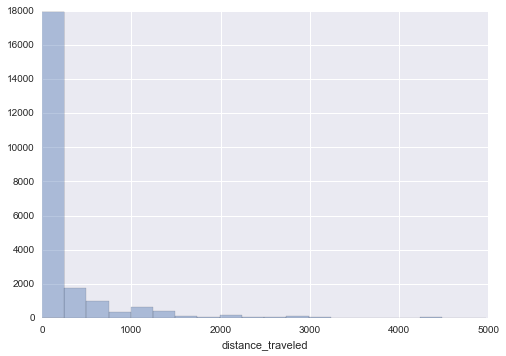

In [63]:
query = '(1 < expenses < 8) & (0 < distance_traveled < 5000)'
sns.distplot(dataset_with_distances.query(query)['distance_traveled'],
             bins=20,
             kde=False)

In [64]:
from sklearn.ensemble import IsolationForest

In [65]:
predictor_keys = ['mean', 'expenses', 'sum', 'distance_traveled']

model = IsolationForest(random_state=0)
model.fit(dataset_with_distances[predictor_keys])

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=0,
        verbose=0)

In [66]:
query = '(congressperson_name == "DR. ADILSON SOARES")'
expected_abnormal_day = dataset_with_distances[is_anomaly] \
    .query(query) \
    .sort_values('expenses', ascending=False).iloc[0]

expected_abnormal_day

congressperson_name                 DR. ADILSON SOARES
issue_date                         2014-11-13 00:00:00
sum                                             419.12
mean                                             52.39
expenses                                             8
city_list              RIO DE JANEIRO,NITEROI,BRASILIA
city                                                 3
distance_traveled                               6472.3
3_stds_anomaly                                    True
5_stds_anomaly                                    True
Name: 29024, dtype: object

In [67]:
model.predict([expected_abnormal_day[predictor_keys]])

array([-1])

In [68]:
y = model.predict(dataset_with_distances[predictor_keys])
dataset_with_distances['isolation_forest_anomaly'] = y == -1
dataset_with_distances['isolation_forest_anomaly'].sum()

13071

Too many anomalies found.

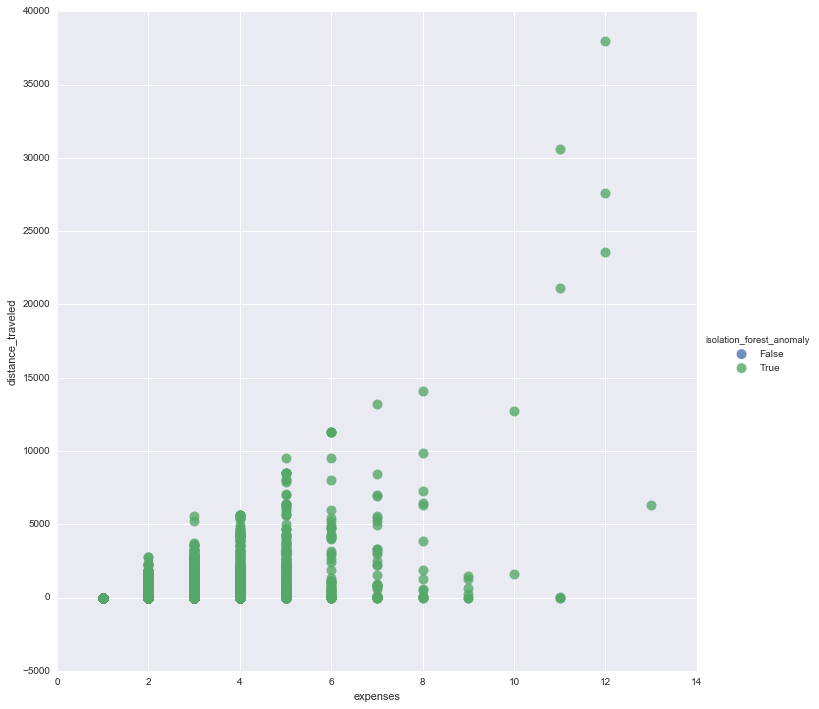

In [69]:
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances,
           fit_reg=False,
           hue='isolation_forest_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

How about changing the predictor keys for something more prone to trigger illegal expenses (# of expenses and distance between cities of expenses each day)?

In [70]:
predictor_keys = ['expenses', 'distance_traveled']

model = IsolationForest(contamination=.001, random_state=0)
model.fit(dataset_with_distances[predictor_keys])
model.predict([expected_abnormal_day[predictor_keys]])

array([-1])

In [71]:
y = model.predict(dataset_with_distances[predictor_keys])
dataset_with_distances['isolation_forest_anomaly'] = y == -1
dataset_with_distances['isolation_forest_anomaly'].sum()

139

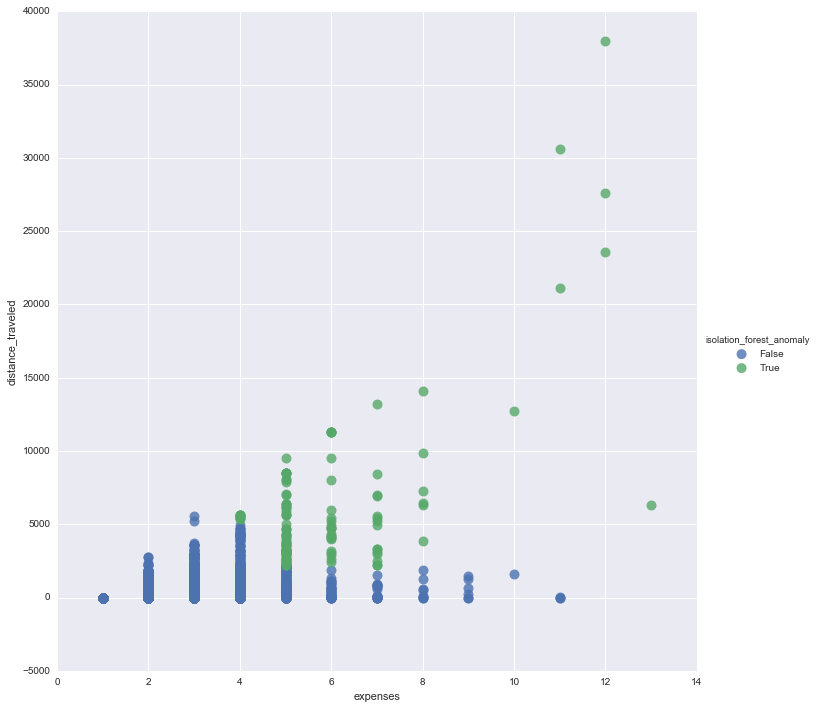

In [72]:
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances,
           fit_reg=False,
           hue='isolation_forest_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

In [73]:
dataset_with_distances.query('isolation_forest_anomaly') \
    .groupby('congressperson_name')['expenses'].count().reset_index() \
    .rename(columns={'expenses': 'abnormal_days'}) \
    .sort_values('abnormal_days', ascending=False) \
    .head(10)

,congressperson_name,abnormal_days
24,SANDRA ROSADO,34
8,DR. ADILSON SOARES,28
27,ZECA DIRCEU,13
12,FRANCISCO DE ASSIS,11
13,FRANCISCO FLORIANO,9
22,RENATO MOLLING,7
14,JORGE SOLLA,6
25,TAKAYAMA,4
4,ANTÔNIO JÁCOME,3
20,PAULO WAGNER,3


## Local Outlier Factor

In [74]:
# Authors: Nicolas Goix <nicolas.goix@telecom-paristech.fr>
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
# License: BSD 3 clause

import numpy as np
from warnings import warn
from scipy.stats import scoreatpercentile

from sklearn.neighbors.base import NeighborsBase
from sklearn.neighbors.base import KNeighborsMixin
from sklearn.neighbors.base import UnsupervisedMixin

from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array

__all__ = ["LocalOutlierFactor"]


class LocalOutlierFactor(NeighborsBase, KNeighborsMixin, UnsupervisedMixin):
    """Unsupervised Outlier Detection using Local Outlier Factor (LOF)

    The anomaly score of each sample is called Local Outlier Factor.
    It measures the local deviation of density of a given sample with
    respect to its neighbors.
    It is local in that the anomaly score depends on how isolated the object
    is with respect to the surrounding neighborhood.
    More precisely, locality is given by k-nearest neighbors, whose distance
    is used to estimate the local density.
    By comparing the local density of a sample to the local densities of
    its neighbors, one can identify samples that have a substantially lower
    density than their neighbors. These are considered outliers.

    Parameters
    ----------
    n_neighbors : int, optional (default=20)
        Number of neighbors to use by default for :meth:`kneighbors` queries.
        If n_neighbors is larger than the number of samples provided,
        all samples will be used.

    algorithm : {'auto', 'ball_tree', 'kd_tree', 'brute'}, optional
        Algorithm used to compute the nearest neighbors:

        - 'ball_tree' will use :class:`BallTree`
        - 'kd_tree' will use :class:`KDTree`
        - 'brute' will use a brute-force search.
        - 'auto' will attempt to decide the most appropriate algorithm
          based on the values passed to :meth:`fit` method.

        Note: fitting on sparse input will override the setting of
        this parameter, using brute force.

    leaf_size : int, optional (default=30)
        Leaf size passed to :class:`BallTree` or :class:`KDTree`. This can
        affect the speed of the construction and query, as well as the memory
        required to store the tree. The optimal value depends on the
        nature of the problem.

    p : integer, optional (default=2)
        Parameter for the Minkowski metric from
        :ref:`sklearn.metrics.pairwise.pairwise_distances`. When p = 1, this is
        equivalent to using manhattan_distance (l1), and euclidean_distance
        (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.

    metric : string or callable, default 'minkowski'
        metric used for the distance computation. Any metric from scikit-learn
        or scipy.spatial.distance can be used.

        If 'precomputed', the training input X is expected to be a distance
        matrix.

        If metric is a callable function, it is called on each
        pair of instances (rows) and the resulting value recorded. The callable
        should take two arrays as input and return one value indicating the
        distance between them. This works for Scipy's metrics, but is less
        efficient than passing the metric name as a string.

        Valid values for metric are:

        - from scikit-learn: ['cityblock', 'cosine', 'euclidean', 'l1', 'l2',
          'manhattan']

        - from scipy.spatial.distance: ['braycurtis', 'canberra', 'chebyshev',
          'correlation', 'dice', 'hamming', 'jaccard', 'kulsinski',
          'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto',
          'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath',
          'sqeuclidean', 'yule']

        See the documentation for scipy.spatial.distance for details on these
        metrics:
        http://docs.scipy.org/doc/scipy/reference/spatial.distance.html

    metric_params : dict, optional (default=None)
        Additional keyword arguments for the metric function.

    contamination : float in (0., 0.5), optional (default=0.1)
        The amount of contamination of the data set, i.e. the proportion
        of outliers in the data set. When fitting this is used to define the
        threshold on the decision function.

    n_jobs : int, optional (default=1)
        The number of parallel jobs to run for neighbors search.
        If ``-1``, then the number of jobs is set to the number of CPU cores.
        Affects only :meth:`kneighbors` and :meth:`kneighbors_graph` methods.


    Attributes
    ----------
    negative_outlier_factor_ : numpy array, shape (n_samples,)
        The opposite LOF of the training samples. The lower, the more normal.
        Inliers tend to have a LOF score close to 1, while outliers tend
        to have a larger LOF score.

        The local outlier factor (LOF) of a sample captures its
        supposed 'degree of abnormality'.
        It is the average of the ratio of the local reachability density of
        a sample and those of its k-nearest neighbors.

    n_neighbors_ : integer
        The actual number of neighbors used for :meth:`kneighbors` queries.

    References
    ----------
    .. [1] Breunig, M. M., Kriegel, H. P., Ng, R. T., & Sander, J. (2000, May).
           LOF: identifying density-based local outliers. In ACM sigmod record.
    """
    def __init__(self, n_neighbors=20, algorithm='auto', leaf_size=30,
                 metric='minkowski', p=2, metric_params=None,
                 contamination=0.1, n_jobs=1):
        self._init_params(n_neighbors=n_neighbors,
                          algorithm=algorithm,
                          leaf_size=leaf_size, metric=metric, p=p,
                          metric_params=metric_params, n_jobs=n_jobs)

        self.contamination = contamination

    def fit_predict(self, X, y=None):
        """"Fits the model to the training set X and returns the labels
        (1 inlier, -1 outlier) on the training set according to the LOF score
        and the contamination parameter.


        Parameters
        ----------
        X : array-like, shape (n_samples, n_features), default=None
            The query sample or samples to compute the Local Outlier Factor
            w.r.t. to the training samples.

        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns 1 for anomalies/outliers and -1 for inliers.
        """

        return self.fit(X)._predict()

    def fit(self, X, y=None):
        """Fit the model using X as training data.

        Parameters
        ----------
        X : {array-like, sparse matrix, BallTree, KDTree}
            Training data. If array or matrix, shape [n_samples, n_features],
            or [n_samples, n_samples] if metric='precomputed'.

        Returns
        -------
        self : object
            Returns self.
        """
        if not (0. < self.contamination <= .5):
            raise ValueError("contamination must be in (0, 0.5]")

        super(LocalOutlierFactor, self).fit(X)

        n_samples = self._fit_X.shape[0]
        if self.n_neighbors > n_samples:
            warn("n_neighbors (%s) is greater than the "
                 "total number of samples (%s). n_neighbors "
                 "will be set to (n_samples - 1) for estimation."
                 % (self.n_neighbors, n_samples))
        self.n_neighbors_ = max(1, min(self.n_neighbors, n_samples - 1))

        self._distances_fit_X_, _neighbors_indices_fit_X_ = (
            self.kneighbors(None, n_neighbors=self.n_neighbors_))

        self._lrd = self._local_reachability_density(
            self._distances_fit_X_, _neighbors_indices_fit_X_)

        # Compute lof score over training samples to define threshold_:
        lrd_ratios_array = (self._lrd[_neighbors_indices_fit_X_] /
                            self._lrd[:, np.newaxis])

        self.negative_outlier_factor_ = -np.mean(lrd_ratios_array, axis=1)

        self.threshold_ = -scoreatpercentile(
            -self.negative_outlier_factor_, 100. * (1. - self.contamination))

        return self

    def _predict(self, X=None):
        """Predict the labels (1 inlier, -1 outlier) of X according to LOF.

        If X is None, returns the same as fit_predict(X_train).
        This method allows to generalize prediction to new observations (not
        in the training set). As LOF originally does not deal with new data,
        this method is kept private.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features), default=None
            The query sample or samples to compute the Local Outlier Factor
            w.r.t. to the training samples. If None, makes prediction on the
            training data without considering them as their own neighbors.

        Returns
        -------
        is_inlier : array, shape (n_samples,)
            Returns -1 for anomalies/outliers and +1 for inliers.
        """
        check_is_fitted(self, ["threshold_", "negative_outlier_factor_",
                               "n_neighbors_", "_distances_fit_X_"])

        if X is not None:
            X = check_array(X, accept_sparse='csr')
            is_inlier = np.ones(X.shape[0], dtype=int)
            is_inlier[self._decision_function(X) <= self.threshold_] = -1
        else:
            is_inlier = np.ones(self._fit_X.shape[0], dtype=int)
            is_inlier[self.negative_outlier_factor_ <= self.threshold_] = -1

        return is_inlier

    def _decision_function(self, X):
        """Opposite of the Local Outlier Factor of X (as bigger is better,
        i.e. large values correspond to inliers).

        The argument X is supposed to contain *new data*: if X contains a
        point from training, it consider the later in its own neighborhood.
        Also, the samples in X are not considered in the neighborhood of any
        point.
        The decision function on training data is available by considering the
        opposite of the negative_outlier_factor_ attribute.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The query sample or samples to compute the Local Outlier Factor
            w.r.t. the training samples.

        Returns
        -------
        opposite_lof_scores : array, shape (n_samples,)
            The opposite of the Local Outlier Factor of each input samples.
            The lower, the more abnormal.
        """
        check_is_fitted(self, ["threshold_", "negative_outlier_factor_",
                               "_distances_fit_X_"])

        X = check_array(X, accept_sparse='csr')

        distances_X, neighbors_indices_X = (
            self.kneighbors(X, n_neighbors=self.n_neighbors_))
        X_lrd = self._local_reachability_density(distances_X,
                                                 neighbors_indices_X)

        lrd_ratios_array = (self._lrd[neighbors_indices_X] /
                            X_lrd[:, np.newaxis])

        # as bigger is better:
        return -np.mean(lrd_ratios_array, axis=1)

    def _local_reachability_density(self, distances_X, neighbors_indices):
        """The local reachability density (LRD)

        The LRD of a sample is the inverse of the average reachability
        distance of its k-nearest neighbors.

        Parameters
        ----------
        distances_X : array, shape (n_query, self.n_neighbors)
            Distances to the neighbors (in the training samples `self._fit_X`)
            of each query point to compute the LRD.

        neighbors_indices : array, shape (n_query, self.n_neighbors)
            Neighbors indices (of each query point) among training samples
            self._fit_X.

        Returns
        -------
        local_reachability_density : array, shape (n_samples,)
            The local reachability density of each sample.
        """
        dist_k = self._distances_fit_X_[neighbors_indices,
                                        self.n_neighbors_ - 1]
        reach_dist_array = np.maximum(distances_X, dist_k)

        #  1e-10 to avoid `nan' when when nb of duplicates > n_neighbors_:
        return 1. / (np.mean(reach_dist_array, axis=1) + 1e-10)

In [75]:
# predictor_keys = ['mean', 'expenses', 'sum', 'distance_traveled']
predictor_keys = ['expenses', 'distance_traveled']

model = LocalOutlierFactor(n_jobs=-1)
y = model.fit_predict(dataset_with_distances[predictor_keys])
model._predict([expected_abnormal_day[predictor_keys]])

array([-1])

In [76]:
dataset_with_distances['lof_anomaly'] = y == -1
dataset_with_distances['lof_anomaly'].sum()

125157

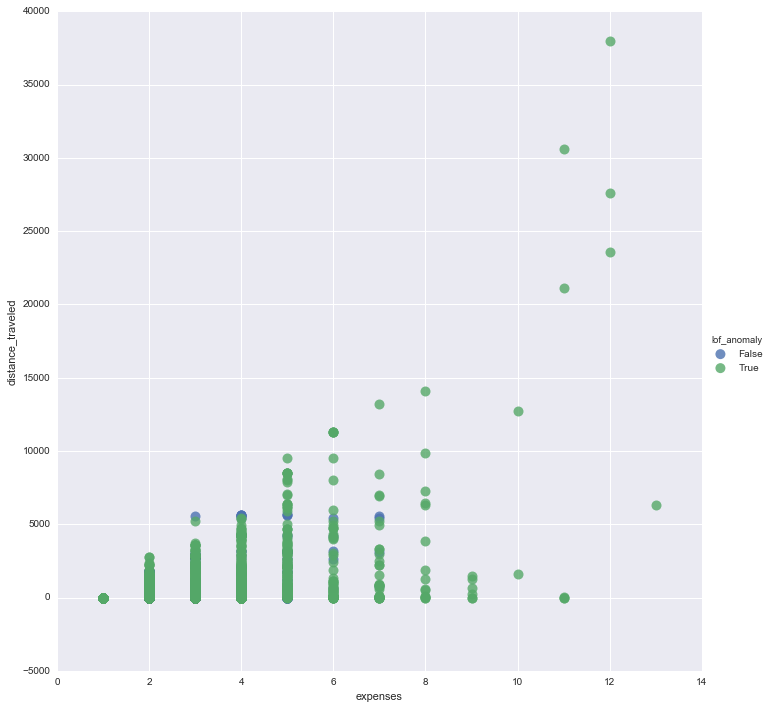

In [77]:
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances,
           fit_reg=False,
           hue='lof_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

Let's see the results using just `distance_traveled` as predictor.

In [78]:
predictor_keys = ['distance_traveled']

model = LocalOutlierFactor(contamination=.01, n_jobs=-1)
y = model.fit_predict(dataset_with_distances[predictor_keys])
model._predict([expected_abnormal_day[predictor_keys]])

array([1])

In [79]:
dataset_with_distances['lof_anomaly'] = y == -1
dataset_with_distances['lof_anomaly'].sum()

1307

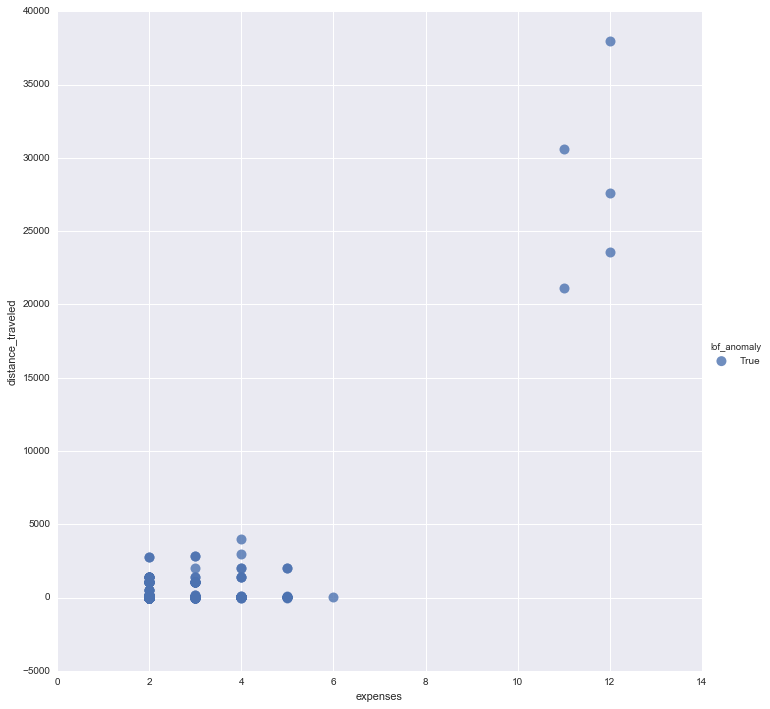

In [80]:
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances.query('lof_anomaly'),
           fit_reg=False,
           hue='lof_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

The congresspeople ranking is similar to the one using standard deviation method.

In [81]:
dataset_with_distances.query('lof_anomaly') \
    .groupby('congressperson_name')['expenses'].count().reset_index() \
    .rename(columns={'expenses': 'abnormal_days'}) \
    .sort_values('abnormal_days', ascending=False) \
    .head(10)

,congressperson_name,abnormal_days
285,VANDERLEI MACRIS,71
75,DR. ADILSON SOARES,37
107,FRANCISCO FLORIANO,35
271,SEVERINO NINHO,31
252,ROBERTO FREIRE,31
279,TAKAYAMA,26
268,SANDRA ROSADO,23
88,EDSON PIMENTA,22
80,DR. UBIALI,20
6,AELTON FREITAS,17


How about trying to combine standard deviation and Local Outlier Factor?

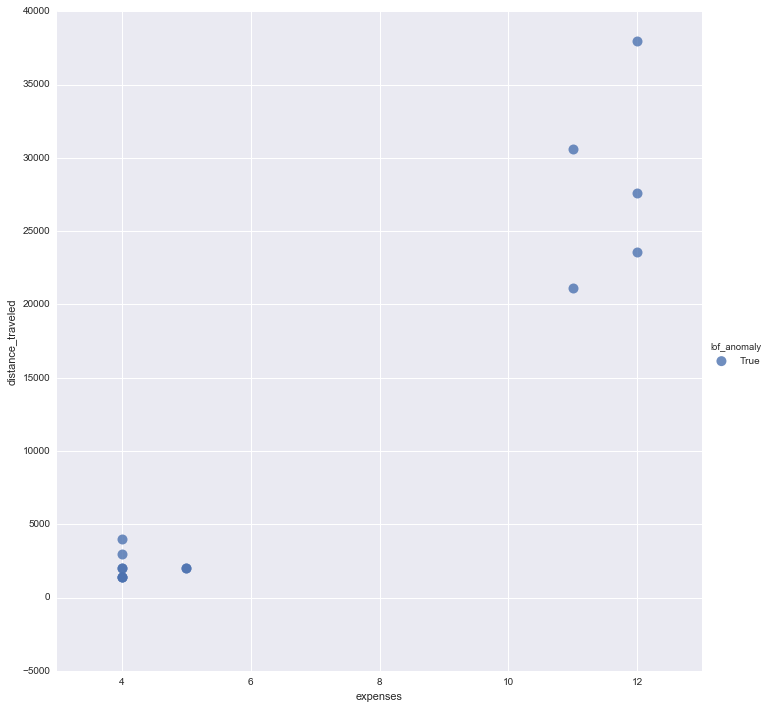

In [82]:
to_show = dataset_with_distances['lof_anomaly'] & \
    dataset_with_distances['3_stds_anomaly']
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances[to_show],
           fit_reg=False,
           hue='lof_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

In [83]:
dataset_with_distances[to_show].shape

(14, 12)

In [84]:
dataset_with_distances[to_show]

,congressperson_name,issue_date,sum,mean,expenses,city_list,city,distance_traveled,3_stds_anomaly,5_stds_anomaly,isolation_forest_anomaly,lof_anomaly
16088,BILAC PINTO,2016-04-07,146.70,29.340000,5,"CARMOPOLIS DE MINAS,ATIBAIA,BRASILIA",3,2028.234593,True,True,False,True
34169,EDMAR ARRUDA,2011-08-18,478.28,119.570000,4,"SAO JOSE DOS PINHAIS,FLORESTA,BRASILIA",3,1391.737324,True,False,False,True
42878,FRANCISCO DE ASSIS,2014-11-19,122.33,30.582500,4,"CORUMBA,CAMPO GRANDE,BRASILIA",3,4015.044777,True,False,False,True
54415,JERÔNIMO GOERGEN,2012-11-23,310.60,77.650000,4,"GARIBALDI,SANTA ROSA,PORTO ALEGRE",3,1431.772631,True,False,False,True
83244,MARINA MAGGESSI,2009-09-10,275.00,68.750000,4,"RIO DE JANEIRO,BRASILIA",2,2006.678985,True,False,False,True
102661,RICARDO IZAR,2014-04-26,238.64,47.728000,5,"BAURU,PRAIA GRANDE,LINS,SAO PAULO,BOITUVA",5,2013.495227,True,True,False,True
106869,ROGÉRIO PENINHA MENDONÇA,2013-12-16,826.14,206.535000,4,"FOZ DO IGUACU,BRASILIA",2,2998.182307,True,False,False,True
112196,SANDRA ROSADO,2012-01-06,281.75,23.479167,12,"MOSSORO,BRASILIA",2,23571.629213,True,True,True,True
112200,SANDRA ROSADO,2012-01-11,541.56,49.232727,11,"NATAL,MOSSORO,BRASILIA",3,30579.442632,True,True,True,True
112201,SANDRA ROSADO,2012-01-12,333.40,27.783333,12,"FORTALEZA,NATAL,MOSSORO,BRASILIA",4,27617.903746,True,True,True,True


In [85]:
dataset_with_distances['lof_anomaly'].describe()

count     130675
unique         2
top        False
freq      129368
Name: lof_anomaly, dtype: object

Number of cities may not be reflected in `distance_traveled` already. Let's see the differencies in the results.

In [86]:
predictor_keys = ['distance_traveled', 'city']

model = LocalOutlierFactor(contamination=.01, n_jobs=-1)
y = model.fit_predict(dataset_with_distances[predictor_keys])
model._predict([expected_abnormal_day[predictor_keys]])

array([1])

In [87]:
dataset_with_distances['lof_anomaly'] = y == -1
dataset_with_distances['lof_anomaly'].sum()

1308

In [88]:
dataset_with_distances.query('lof_anomaly') \
    .groupby('congressperson_name')['expenses'].count().reset_index() \
    .rename(columns={'expenses': 'abnormal_days'}) \
    .sort_values('abnormal_days', ascending=False) \
    .head(10)

,congressperson_name,abnormal_days
283,VANDERLEI MACRIS,79
106,FRANCISCO FLORIANO,43
71,DR. ADILSON SOARES,38
250,ROBERTO FREIRE,33
269,SEVERINO NINHO,29
266,SANDRA ROSADO,27
277,TAKAYAMA,24
85,EDSON PIMENTA,20
87,EDUARDO BARBOSA,19
76,DR. UBIALI,19


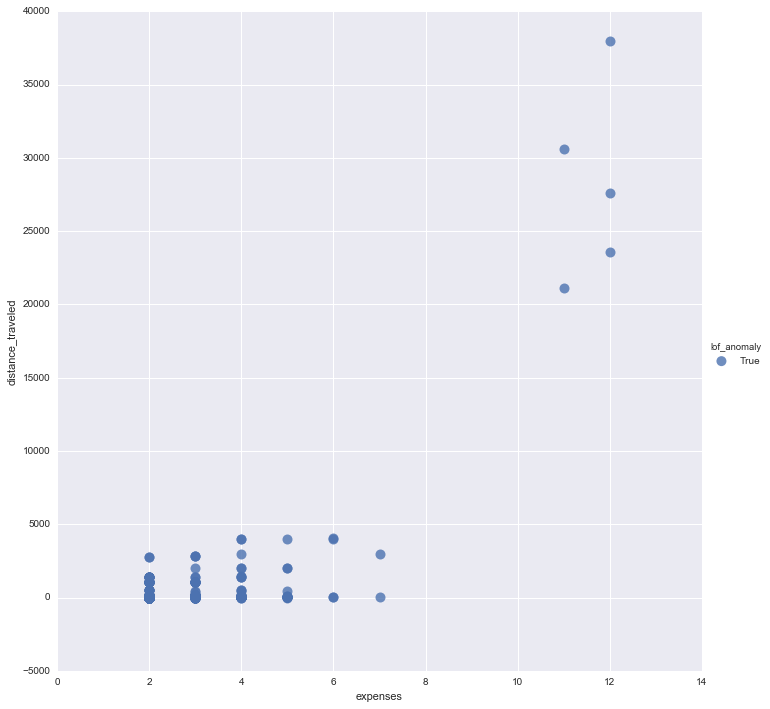

In [89]:
to_show = dataset_with_distances['lof_anomaly']
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances[to_show],
           fit_reg=False,
           hue='lof_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

In [90]:
query = '(lof_anomaly == True) & (congressperson_name == "VANDERLEI MACRIS")'
dataset_with_distances.query(query).sort_values('issue_date', ascending=False).head()

,congressperson_name,issue_date,sum,mean,expenses,city_list,city,distance_traveled,3_stds_anomaly,5_stds_anomaly,isolation_forest_anomaly,lof_anomaly
122546,VANDERLEI MACRIS,2016-09-13,287.5,95.833333,3,BRASILIA,1,6.975089,False,False,False,True
122517,VANDERLEI MACRIS,2016-05-04,213.8,71.266667,3,BRASILIA,1,13.968196,False,False,False,True
122497,VANDERLEI MACRIS,2016-03-14,195.5,97.750000,2,SAO PAULO,1,2.643333,False,False,False,True
122492,VANDERLEI MACRIS,2016-03-07,48.0,24.000000,2,SAO PAULO,1,0.438432,False,False,False,True
122465,VANDERLEI MACRIS,2015-08-14,196.9,65.633333,3,"AMERICANA,CAIEIRAS,CAJAMAR",3,132.170680,False,False,False,True


**So far, `IsolationForest` using `expenses` and `distance_traveled` as predictors seem to have best results for the purpose of this analysis**: allowing deputies to make many expenses (even expensive ones) and traveling through many cities in a single day, but questioning those making too many expenses without the excuse of a business trip.

## Deeper look into winner models

5-stds and `IsolationForest` with `expenses/distance_traveled` as predictors and contamination of 0.1% return the best results. We need to compare them before going further.

In [91]:
predictor_keys = ['expenses', 'distance_traveled']

forest_model = IsolationForest(contamination=.001, random_state=0)
forest_model.fit(dataset_with_distances[predictor_keys])

IsolationForest(bootstrap=False, contamination=0.001, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=0,
        verbose=0)

In [92]:
dataset_with_distances.query('distance_traveled == {}'.format(dataset_with_distances['distance_traveled'].max()))

,congressperson_name,issue_date,sum,mean,expenses,city_list,city,distance_traveled,3_stds_anomaly,5_stds_anomaly,isolation_forest_anomaly,lof_anomaly
112206,SANDRA ROSADO,2012-01-17,287.43,23.9525,12,"FORTALEZA,BRASILIA,MOSSORO",3,37969.07651,True,True,True,True


In [93]:
isolation_ranking = dataset_with_distances.query('isolation_forest_anomaly') \
    .groupby('congressperson_name')['expenses'].count().reset_index() \
    .rename(columns={'expenses': 'abnormal_days'}) \
    .sort_values('abnormal_days', ascending=False)
forest_anomaly_congresspeople = set(isolation_ranking['congressperson_name'])
len(forest_anomaly_congresspeople)

28

In [94]:
stds_ranking = dataset_with_distances[dataset_with_distances['5_stds_anomaly']] \
    .groupby('congressperson_name')['expenses'].count().reset_index() \
    .rename(columns={'expenses': 'abnormal_days'}) \
    .sort_values('abnormal_days', ascending=False)
stds_anomaly_congresspeople = set(stds_ranking['congressperson_name'])
len(stds_anomaly_congresspeople)

36

Congresspeople who are both in `IsolationForest` and `5-stds` models:

In [95]:
common_congresspeople = forest_anomaly_congresspeople & stds_anomaly_congresspeople
common_congresspeople

{'ACELINO POPÓ',
 'AELTON FREITAS',
 'AFONSO MOTTA',
 'ANDRÉ ZACHAROW',
 'ANTÔNIO JÁCOME',
 'ARTUR BRUNO',
 'CELSO MALDANER',
 'CLAUDIO CAJADO',
 'DR. ADILSON SOARES',
 'DR. CARLOS ALBERTO',
 'EDMAR ARRUDA',
 'EDUARDO BARBOSA',
 'FRANCISCO DE ASSIS',
 'FRANCISCO FLORIANO',
 'JORGE SOLLA',
 'MAIA FILHO',
 'MARCOS ROGÉRIO',
 'MARGARIDA SALOMÃO',
 'MARINA MAGGESSI',
 'PAULO WAGNER',
 'PAULÃO',
 'RENATO MOLLING',
 'RUBENS BUENO',
 'SANDRA ROSADO',
 'TAKAYAMA',
 'VANDERLEI MACRIS',
 'ZECA DIRCEU'}

Congresspeople who are just in `IsolationForest` or `5-stds` model:

In [96]:
forest_anomaly_congresspeople ^ stds_anomaly_congresspeople

{'ABELARDO LUPION',
 'BILAC PINTO',
 'EVANDRO GUSSI',
 'GERALDO THADEU',
 'MARINALDO ROSENDO',
 'MISAEL VARELLA',
 'ODAIR CUNHA',
 'POMPEO DE MATTOS',
 'RICARDO IZAR',
 'WASHINGTON LUIZ'}

In [97]:
congresspeople_ranking = pd.merge(isolation_ranking, stds_ranking,
                                  how='outer',
                                  on='congressperson_name',
                                  suffixes=('_isolation', '_stds'))

In [98]:
congresspeople_ranking['isolation_stds_diff'] = \
    abs(congresspeople_ranking['abnormal_days_isolation'] - \
        congresspeople_ranking['abnormal_days_stds'])
congresspeople_ranking.head()

,congressperson_name,abnormal_days_isolation,abnormal_days_stds,isolation_stds_diff
0,SANDRA ROSADO,34.0,30.0,4.0
1,DR. ADILSON SOARES,28.0,41.0,13.0
2,ZECA DIRCEU,13.0,14.0,1.0
3,FRANCISCO DE ASSIS,11.0,13.0,2.0
4,FRANCISCO FLORIANO,9.0,12.0,3.0


In [99]:
congresspeople_ranking['ranking'] = \
    np.mean(congresspeople_ranking[['abnormal_days_isolation', 'abnormal_days_stds']], axis=1) - congresspeople_ranking['isolation_stds_diff']

In [100]:
congresspeople_ranking.sort_values('ranking', ascending=False)

,congressperson_name,abnormal_days_isolation,abnormal_days_stds,isolation_stds_diff,ranking
0,SANDRA ROSADO,34.0,30.0,4.0,28.0
1,DR. ADILSON SOARES,28.0,41.0,13.0,21.5
2,ZECA DIRCEU,13.0,14.0,1.0,12.5
3,FRANCISCO DE ASSIS,11.0,13.0,2.0,10.0
4,FRANCISCO FLORIANO,9.0,12.0,3.0,7.5
6,JORGE SOLLA,6.0,6.0,0.0,6.0
5,RENATO MOLLING,7.0,10.0,3.0,5.5
7,TAKAYAMA,4.0,4.0,0.0,4.0
9,PAULO WAGNER,3.0,3.0,0.0,3.0
10,ACELINO POPÓ,2.0,2.0,0.0,2.0


In [101]:
is_in_both_models = \
    dataset_with_distances['congressperson_name'].isin(common_congresspeople) & \
    dataset_with_distances['5_stds_anomaly'] & \
    dataset_with_distances['isolation_forest_anomaly']
dataset_with_distances[is_in_both_models].sort_values('distance_traveled', ascending=False)

,congressperson_name,issue_date,sum,mean,expenses,city_list,city,distance_traveled,3_stds_anomaly,5_stds_anomaly,isolation_forest_anomaly,lof_anomaly
112206,SANDRA ROSADO,2012-01-17,287.43,23.952500,12,"FORTALEZA,BRASILIA,MOSSORO",3,37969.076510,True,True,True,True
112200,SANDRA ROSADO,2012-01-11,541.56,49.232727,11,"NATAL,MOSSORO,BRASILIA",3,30579.442632,True,True,True,True
112201,SANDRA ROSADO,2012-01-12,333.40,27.783333,12,"FORTALEZA,NATAL,MOSSORO,BRASILIA",4,27617.903746,True,True,True,True
112196,SANDRA ROSADO,2012-01-06,281.75,23.479167,12,"MOSSORO,BRASILIA",2,23571.629213,True,True,True,True
112204,SANDRA ROSADO,2012-01-15,295.58,26.870909,11,"MOSSORO,BRASILIA",2,21144.918842,True,True,True,True
112205,SANDRA ROSADO,2012-01-16,182.14,22.767500,8,"MOSSORO,BRASILIA",2,14072.247943,True,True,True,False
112210,SANDRA ROSADO,2012-01-23,139.42,19.917143,7,"NATAL,MOSSORO,BRASILIA",3,13185.187380,True,True,True,False
112198,SANDRA ROSADO,2012-01-09,340.18,34.018000,10,"NATAL,BRASILIA,MOSSORO",3,12717.700035,True,True,True,False
112248,SANDRA ROSADO,2012-03-28,225.73,37.621667,6,"NATAL,BRASILIA",2,11324.130379,True,True,True,False
112221,SANDRA ROSADO,2012-02-08,309.46,51.576667,6,"NATAL,BRASILIA",2,11320.374327,True,True,True,False


In [102]:
dataset_with_distances['lof_and_5_stds'] = dataset_with_distances['isolation_forest_anomaly'] & dataset_with_distances['5_stds_anomaly']
dataset_with_distances['lof_or_5_stds'] = dataset_with_distances['isolation_forest_anomaly'] | dataset_with_distances['5_stds_anomaly']

### 5 standard deviations from the mean

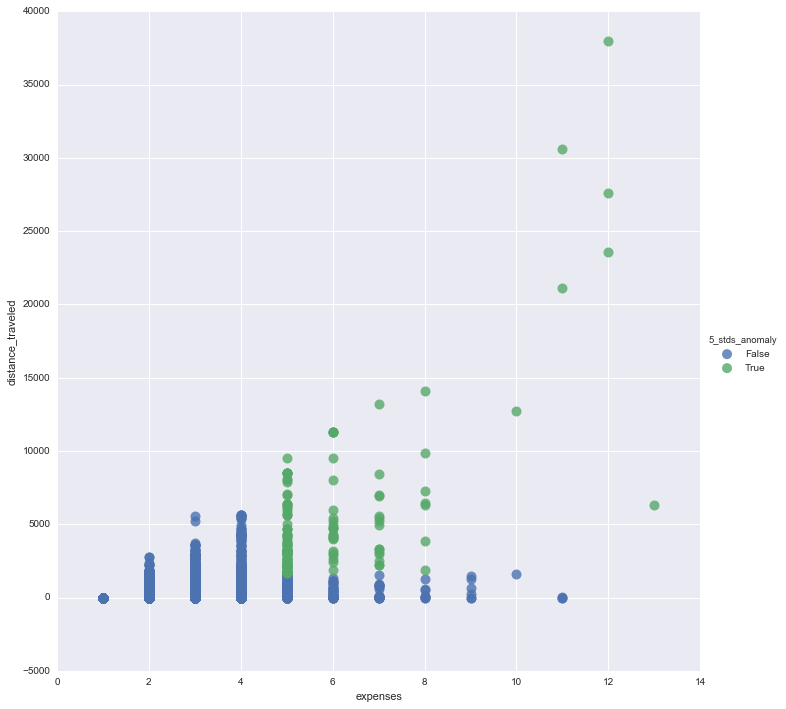

In [103]:
sns.lmplot('expenses', 'distance_traveled',
           data=dataset_with_distances,
           fit_reg=False,
           hue='5_stds_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

### IsolationForest

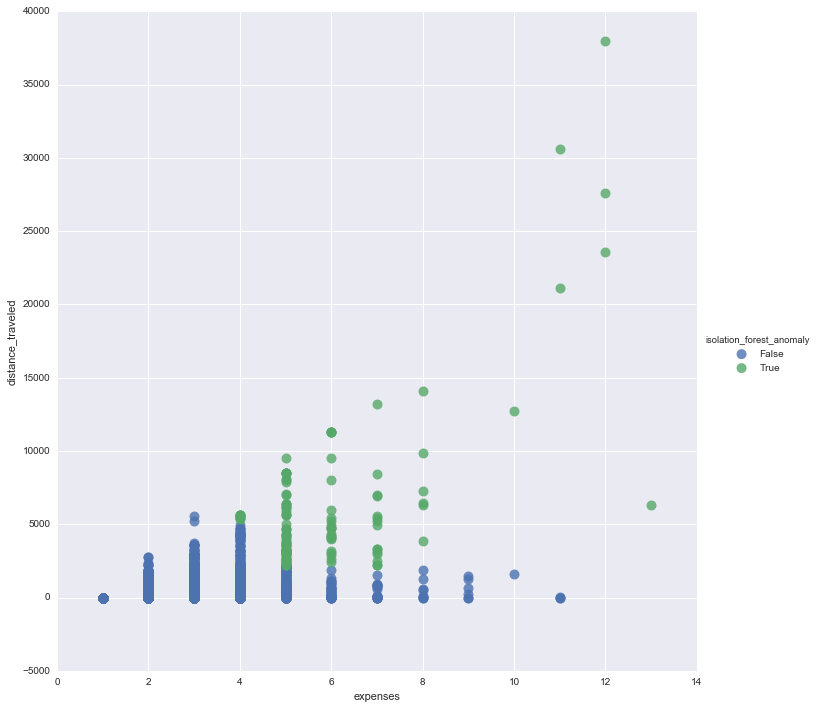

In [104]:
sns.lmplot('expenses', 'distance_traveled',
           data=dataset_with_distances,
           fit_reg=False,
           hue='isolation_forest_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

### 5 standard deviations AND IsolationForest

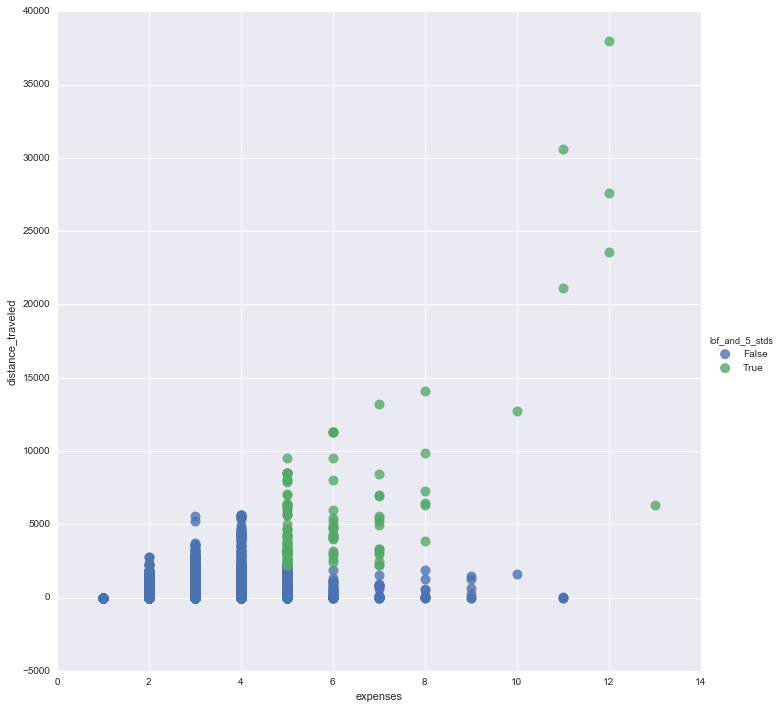

In [105]:
sns.lmplot('expenses', 'distance_traveled',
           data=dataset_with_distances,
           fit_reg=False,
           hue='lof_and_5_stds',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

### 5 standard deviations OR IsolationForest

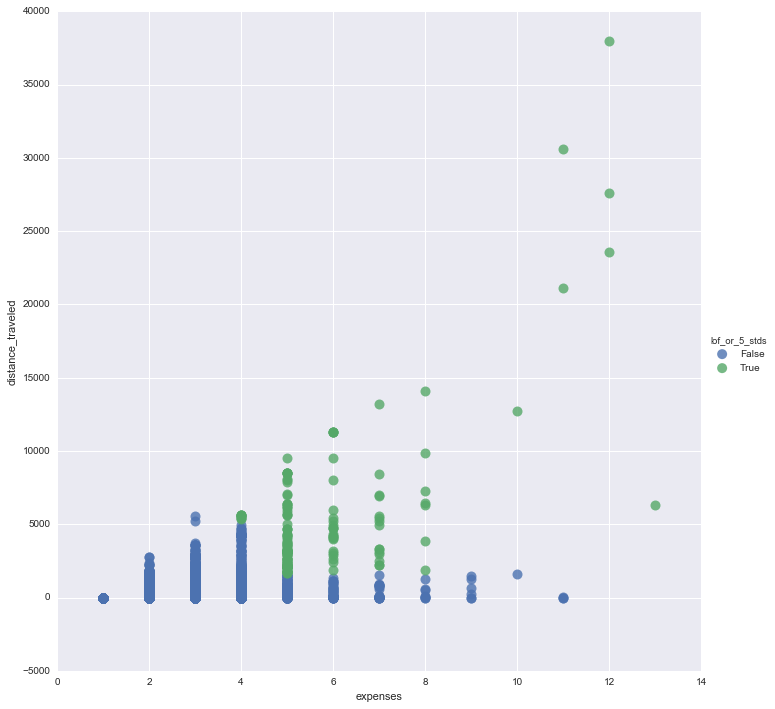

In [106]:
sns.lmplot('expenses', 'distance_traveled',
           data=dataset_with_distances,
           fit_reg=False,
           hue='lof_or_5_stds',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

## Anomalies in groups of days

In [107]:
dataset['issue_date_day'] = dataset['issue_date'].apply(lambda date: date.day)
dataset['issue_date_month'] = dataset['issue_date'].apply(lambda date: date.month)
dataset['issue_date_year'] = dataset['issue_date'].apply(lambda date: date.year)
dataset['issue_date_weekday'] = dataset['issue_date'].apply(lambda date: date.weekday())
dataset['issue_date_week'] = dataset['issue_date'].apply(lambda date: date.week)

In [108]:
# keys = ['applicant_id', 'issue_date_week', 'issue_date_year']
keys = ['congressperson_name', 'issue_date_week', 'issue_date_year']
aggregation_weeks = dataset.groupby(keys)['total_net_value']. \
    agg({'sum': np.sum, 'expenses': len, 'mean': np.mean})

In [109]:
aggregation_weeks['expenses'] = aggregation_weeks['expenses'].astype(np.int)
aggregation_weeks.sort_values(['expenses', 'sum'], ascending=[False, False]).head(10)

sum       mean  \
congressperson_name issue_date_week issue_date_year                       
SANDRA ROSADO       2               2012             1885.14  31.951525   
FRANCISCO DE ASSIS  47              2014             1842.96  48.498947   
                    49              2014             1808.35  47.588158   
                    48              2014             1935.24  53.756667   
                    40              2014             1253.20  36.858824   
SANDRA ROSADO       1               2012              886.43  26.861515   
FRANCISCO DE ASSIS  41              2014             1188.00  37.125000   
DR. ADILSON SOARES  15              2014             1445.73  49.852759   
                    6               2014             1499.73  55.545556   
VANDERLEI MACRIS    49              2011             1118.99  43.038077   

                                                     expenses  
congressperson_name issue_date_week issue_date_year            
SANDRA ROSADO       2               2012                   59  
FRANCISCO DE ASSIS  47              2014                   38  
                    49              2014                   38  
                    48              2014                   36  
                    40              2014                   34  
SANDRA ROSADO       1               2012                   33  
FRANCISCO DE ASSIS  41              2014                   32  
DR. ADILSON SOARES  15              2014                   29  
                    6               2014                   27  
VANDERLEI MACRIS    49              2011                   26

In [110]:
cities_weeks = dataset.groupby(keys)['city']. \
    agg({'city': lambda x: len(set(x)),
         'city_list': lambda x: ','.join(set(x))}
       ).sort_values('city', ascending=False)
cities_weeks.head()

,,,city_list,city
congressperson_name,issue_date_week,issue_date_year,,
FRANCISCO DE ASSIS,41,2014,"ARARANGUA,TIJUCAS,PROMISSAO,PAULO LOPES,SAO PA...",13
TAKAYAMA,25,2014,"RIBEIRAO DO PINHAL,MARINGA,MARECHAL CANDIDO RO...",12
FRANCISCO DE ASSIS,40,2014,"ARARANGUA,CAMPO DO TENENTE,MAFRA,PAULO LOPES,J...",12
TAKAYAMA,26,2014,"MARECHAL CANDIDO RONDON,GUARAPUAVA,LARANJEIRAS...",12
JERÔNIMO GOERGEN,26,2011,"CACHOEIRA DO SUL,LAJEADO,ROSARIO DO SUL,PAVERA...",11


In [111]:
def calculate_sum_distances(x):
    coordinate_list = x[['latitude', 'longitude']].values
    edges = list(combinations(coordinate_list, 2))
    return np.sum([distance(edge[0][1:], edge[1][1:]).km for edge in edges])

distances_weeks = dataset.groupby(keys).apply(calculate_sum_distances)

In [112]:
distances_weeks = distances_weeks.reset_index() \
    .rename(columns={0: 'distance_traveled'}) \
    .sort_values('distance_traveled', ascending=False)
distances_weeks.head()

,congressperson_name,issue_date_week,issue_date_year,distance_traveled
50694,SANDRA ROSADO,2,2012,578329.761315
50700,SANDRA ROSADO,3,2012,191833.009850
50689,SANDRA ROSADO,1,2012,179401.660027
50710,SANDRA ROSADO,5,2011,167688.525850
18708,FRANCISCO DE ASSIS,40,2014,164803.952533


In [113]:
aggregation_weeks = pd.merge(aggregation_weeks.reset_index(), cities_weeks.reset_index())

In [114]:
dataset_with_distances_weeks = \
    pd.merge(aggregation_weeks,
             distances_weeks,
             left_on=keys,
             right_on=keys)
dataset_with_distances_weeks.sort_values(['distance_traveled', 'expenses'], ascending=[False, False]).head(10)

,congressperson_name,issue_date_week,issue_date_year,sum,mean,expenses,city_list,city,distance_traveled
50694,SANDRA ROSADO,2,2012,1885.14,31.951525,59,"FORTALEZA,NATAL,MOSSORO,BRASILIA",4,578329.761315
50700,SANDRA ROSADO,3,2012,615.04,23.655385,26,"FORTALEZA,NATAL,MOSSORO,BRASILIA",4,191833.009850
50689,SANDRA ROSADO,1,2012,886.43,26.861515,33,"NATAL,SAO JOSE DE MIPIBU,MOSSORO,BRASILIA",4,179401.660027
50710,SANDRA ROSADO,5,2011,920.00,35.384615,26,"NATAL,MOSSORO,BRASILIA",3,167688.525850
18708,FRANCISCO DE ASSIS,40,2014,1253.20,36.858824,34,"ARARANGUA,CAMPO DO TENENTE,MAFRA,PAULO LOPES,J...",12,164803.952533
18715,FRANCISCO DE ASSIS,47,2014,1842.96,48.498947,38,"ARARANGUA,MIRANDA,JOINVILLE,CORUMBA,BRASILIA,C...",7,160362.783073
50849,SANDRA ROSADO,33,2012,1245.46,56.611818,22,"NATAL,BRASILIA,MOSSORO",3,150345.592237
50837,SANDRA ROSADO,31,2012,928.61,37.144400,25,"NATAL,MOSSORO,BRASILIA",3,149845.556519
50843,SANDRA ROSADO,32,2012,621.66,29.602857,21,"NATAL,MOSSORO,BRASILIA",3,148243.614283
18709,FRANCISCO DE ASSIS,41,2014,1188.00,37.125000,32,"ARARANGUA,TIJUCAS,PROMISSAO,PAULO LOPES,SAO PA...",13,145253.217319


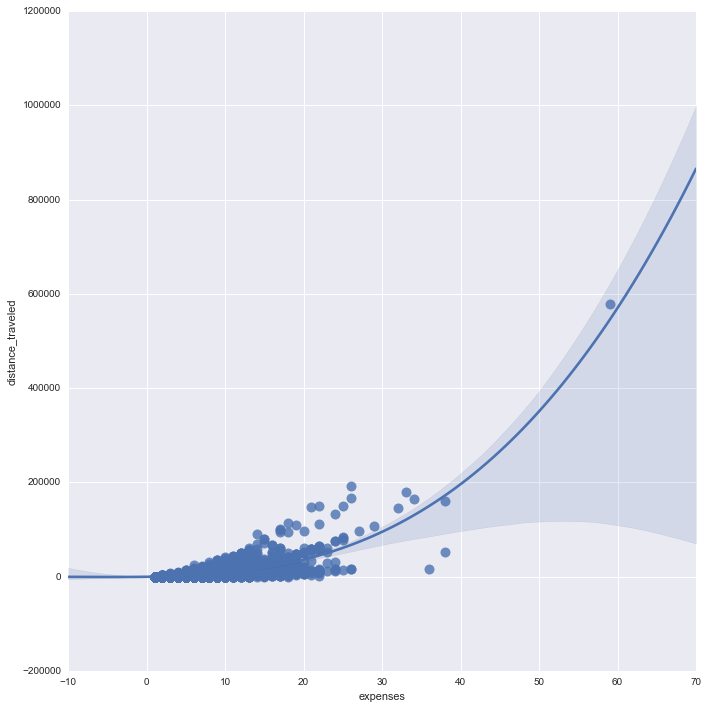

In [115]:
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances_weeks,
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10,
           order=3)

In [116]:
dataset_with_distances_weeks.describe()

,issue_date_week,issue_date_year,sum,mean,expenses,city,distance_traveled
count,58754.000000,58754.000000,58754.000000,58754.000000,58754.000000,58754.000000,58754.000000
mean,26.503115,2012.851380,183.839994,69.664243,2.869047,1.606018,1088.618828
std,14.039406,2.312373,203.912930,91.444559,2.464365,0.981004,4926.376650
min,1.000000,2001.000000,1.500000,1.500000,1.000000,1.000000,0.000000
25%,15.000000,2011.000000,58.700000,34.620000,1.000000,1.000000,0.000000
50%,26.000000,2013.000000,123.280000,52.868750,2.000000,1.000000,3.372865
75%,39.000000,2015.000000,236.127500,86.000000,4.000000,2.000000,542.175207
max,53.000000,2209.000000,6968.960000,5852.000000,59.000000,13.000000,578329.761315


4 "meals" every weekday

In [117]:
dataset_with_distances_weeks[dataset_with_distances_weeks['expenses'] > 20].shape

(63, 9)

In [118]:
expenses_ceiling = dataset_with_distances_weeks['expenses'].mean() + \
    (5 * dataset_with_distances_weeks['expenses'].std())
distance_traveled_ceiling = dataset_with_distances_weeks['distance_traveled'].mean() + \
    (5 * dataset_with_distances_weeks['distance_traveled'].std())
is_anomaly = (dataset_with_distances_weeks['expenses'] > expenses_ceiling) & \
    (dataset_with_distances_weeks['distance_traveled'] > distance_traveled_ceiling)
dataset_with_distances_weeks[is_anomaly].shape

(96, 9)

In [119]:
expenses_ceiling, distance_traveled_ceiling

(15.190870614089029, 25720.502077997226)

In [120]:
dataset_with_distances_weeks[is_anomaly] \
    .groupby('congressperson_name')['expenses'].count().reset_index() \
    .rename(columns={'expenses': 'abnormal_weeks'}) \
    .sort_values('abnormal_weeks', ascending=False) \
    .head(10)

,congressperson_name,abnormal_weeks
5,DR. ADILSON SOARES,47
12,SANDRA ROSADO,15
7,FRANCISCO DE ASSIS,8
14,ZECA DIRCEU,6
8,FRANCISCO FLORIANO,4
13,TAKAYAMA,4
9,JORGE SOLLA,3
11,PAULO WAGNER,2
0,ACELINO POPÓ,1
1,AELTON FREITAS,1


In [121]:
dataset_with_distances_weeks['5_stds_anomaly'] = is_anomaly
dataset_with_distances_weeks['5_stds_anomaly'].sum() / len(dataset_with_distances_weeks)

0.001633931306804643

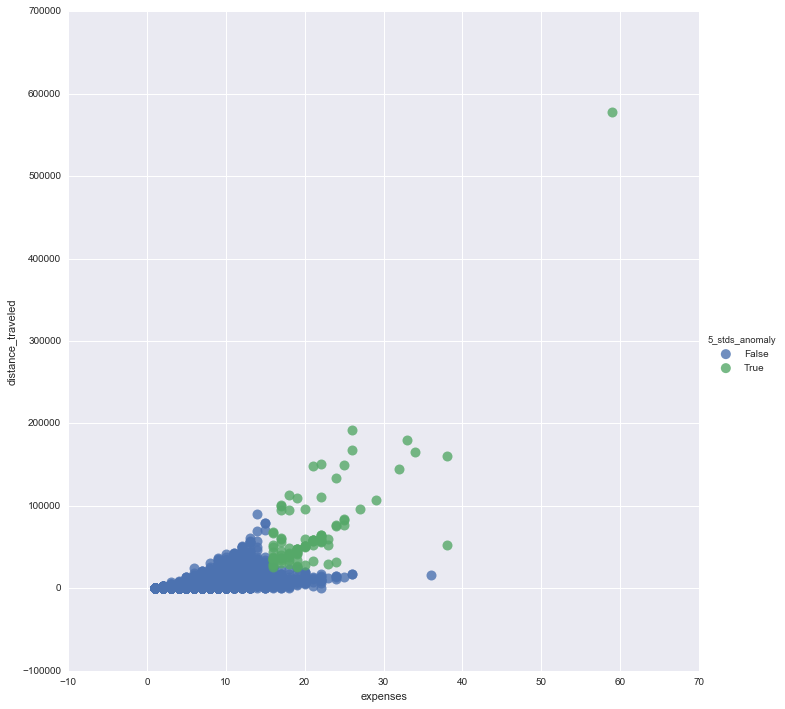

In [122]:
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances_weeks,
           fit_reg=False,
           hue='5_stds_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

In [123]:
predictor_keys = ['issue_date_week', 'issue_date_year', 'expenses', 'distance_traveled']

model = IsolationForest(contamination=.001, random_state=0)
model.fit(dataset_with_distances_weeks[predictor_keys])
y = model.predict(dataset_with_distances_weeks[predictor_keys])
dataset_with_distances_weeks['isolation_forest_anomaly'] = y == -1
dataset_with_distances_weeks['isolation_forest_anomaly'].sum()

59

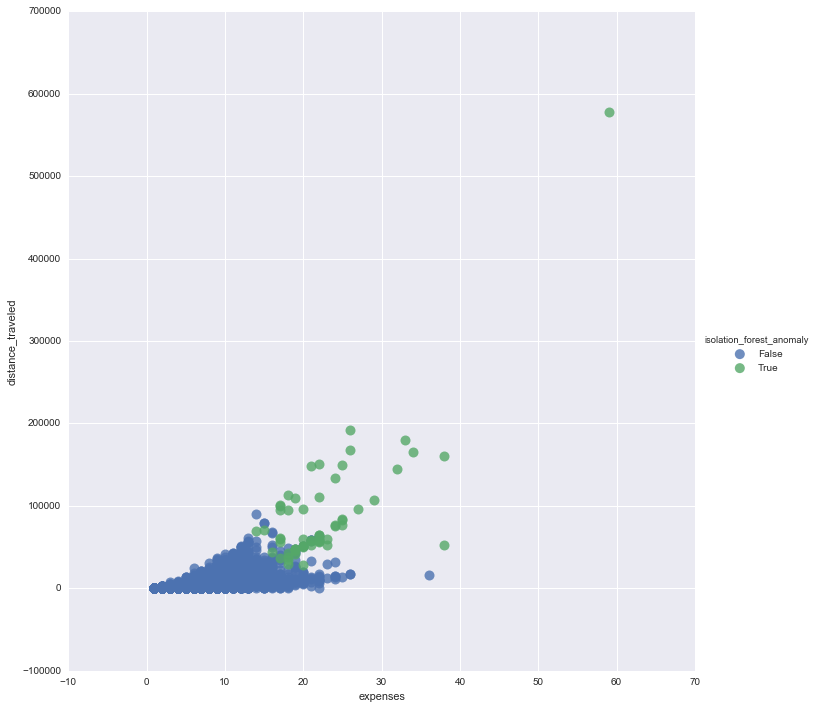

In [124]:
sns.lmplot('expenses', 'distance_traveled', 
           data=dataset_with_distances_weeks,
           fit_reg=False,
           hue='isolation_forest_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10)

**Ideas**

* Come up with ways of giving a outlier-ness degree (i.e. how anomalous each day or week was).
* Combine anomalous weeks with days. A anomalous day in a anomalous week has a higher outlier-ness degree.
* Try linear regression as a Anomaly Detection method.

## Combining IsolationForest with hardcoded threshold

17


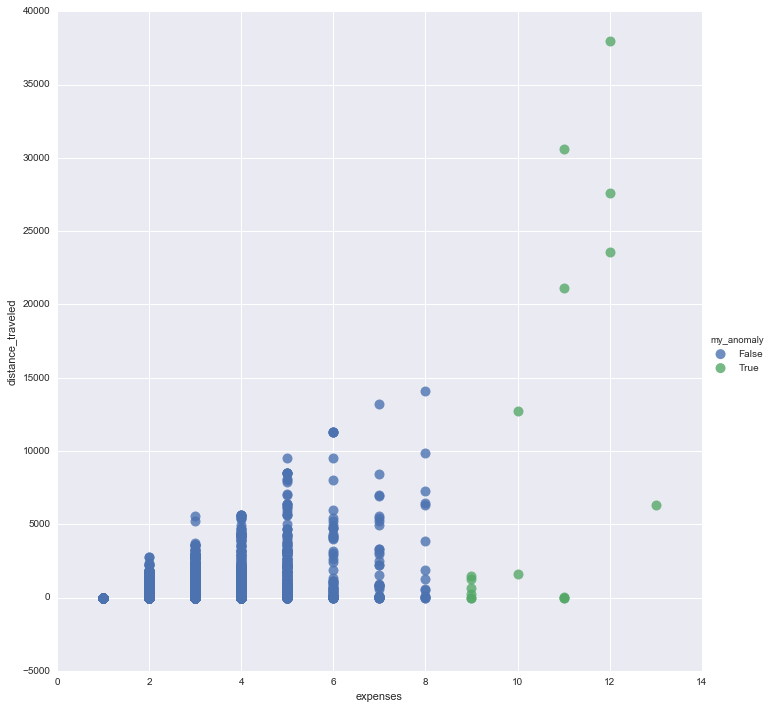

In [125]:
expenses_threshold = dataset_with_distances['expenses'].mean() + \
    (10 * dataset_with_distances['expenses'].std())
dataset_with_distances['my_anomaly'] = dataset_with_distances['expenses'] > 8
dataset_with_distances['my_and_forest_anomaly'] = \
    dataset_with_distances['my_anomaly'] | \
    dataset_with_distances['isolation_forest_anomaly']
print(dataset_with_distances['my_anomaly'].sum())
sns.lmplot('expenses', 'distance_traveled',
           data=dataset_with_distances,
           hue='my_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           size=10,
           fit_reg=False)

In [126]:
dataset_with_distances[dataset_with_distances['my_anomaly']] \
    .groupby('congressperson_name')['expenses'].count().reset_index() \
    .rename(columns={'expenses': 'abnormal_days'}) \
    .sort_values('abnormal_days', ascending=False) \
    .head(10)

,congressperson_name,abnormal_days
6,SANDRA ROSADO,8
2,FRANCISCO DE ASSIS,2
5,PAULO WAGNER,2
0,CELSO MALDANER,1
1,DR. ADILSON SOARES,1
3,LÉO VIVAS,1
4,MAGDA MOFATTO,1
7,VANDERLEI MACRIS,1


## Combining polynomial regression with hardcoded threshold

In fact, getting feedback from other people from the team, I came to the conclusion that the cases we want to report as "anomalies" are related with a regression.

First: cases with more than 8 meal receipts in a single day we want to get reported, doesn't matter the distance. Secondly: people traveling are expected to request for more meal reimbursements (e.g. coffee before going to the airport, something quick before checkin, more calm breakfast waiting for the flight... all of this in the same day, still legal), but many receipts in the same day, with short distance traveled is suspect. Still, too many receipts is still suspect. Thus what we expect is to form a regression, give an acceptable margin and consider everything outside, above and below it, suspect.

[  10.63406588  -28.62829149  121.16402433 -105.06034151]


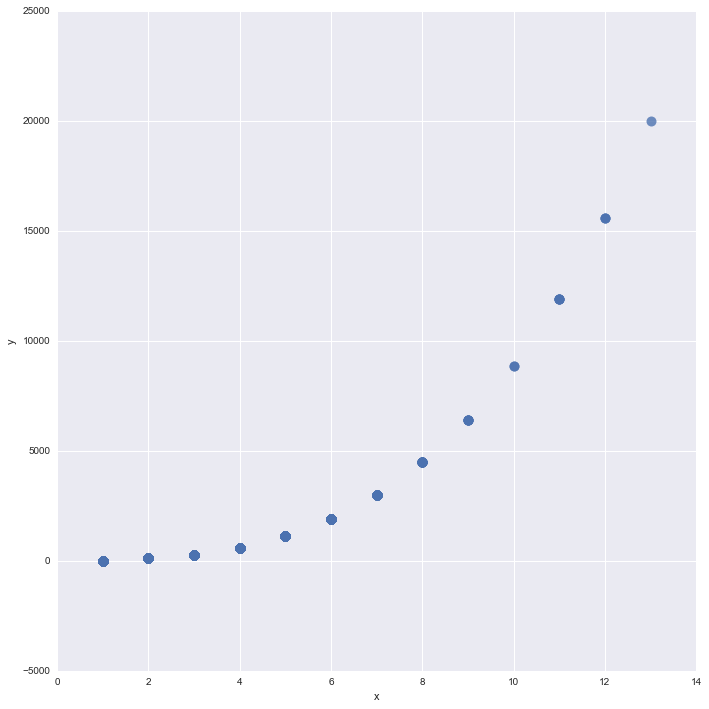

In [127]:
to_plot = pd.DataFrame()
to_plot['x'] = dataset_with_distances['expenses'].astype(np.long)

fit = np.polyfit(to_plot['x'],
                 dataset_with_distances['distance_traveled'].astype(np.long),
                 3)
print(fit)
fit_fn = np.poly1d(fit)
to_plot['y'] = fit_fn(dataset_with_distances['expenses'])

sns.lmplot('x', 'y', 
           data=to_plot,
           scatter_kws={'marker': 'D',
                        's': 100},
           fit_reg=False,
           size=10)

In [128]:
dataset_with_distances['expected_distance'] = \
    fit_fn(dataset_with_distances['expenses'])

We want to limit the contamination to 0.1% (`diff_distance` approximately 3,000).

In [129]:
expected_distances = dataset_with_distances['expected_distance']
diff_distance = abs(expected_distances - dataset_with_distances['distance_traveled'])

def contamination(threshold):
    return (diff_distance > threshold).sum() / \
        (len(dataset_with_distances) - dataset_with_distances['my_anomaly'].sum())

def threshold_for_contamination(expected_contamination):
    possible_thresholds = range(1, int(expected_distances.max()), 50)
    results = [(contamination(x), x) for x in possible_thresholds]
    best_choice = min(results, key=lambda x: abs(x[0] - expected_contamination))
    return best_choice[1]

In [130]:
threshold_for_contamination(.001)

3001

In [131]:
dataset_with_distances['polyfit_anomaly'] = \
    diff_distance > threshold_for_contamination(.001)
dataset_with_distances['polyfit_anomaly'].sum()

125

In [132]:
dataset_with_distances['my_and_polyfit_anomaly'] = \
    dataset_with_distances['my_anomaly'] | \
    dataset_with_distances['polyfit_anomaly']

In [133]:
dataset_with_distances['my_and_polyfit_anomaly'].sum()

125

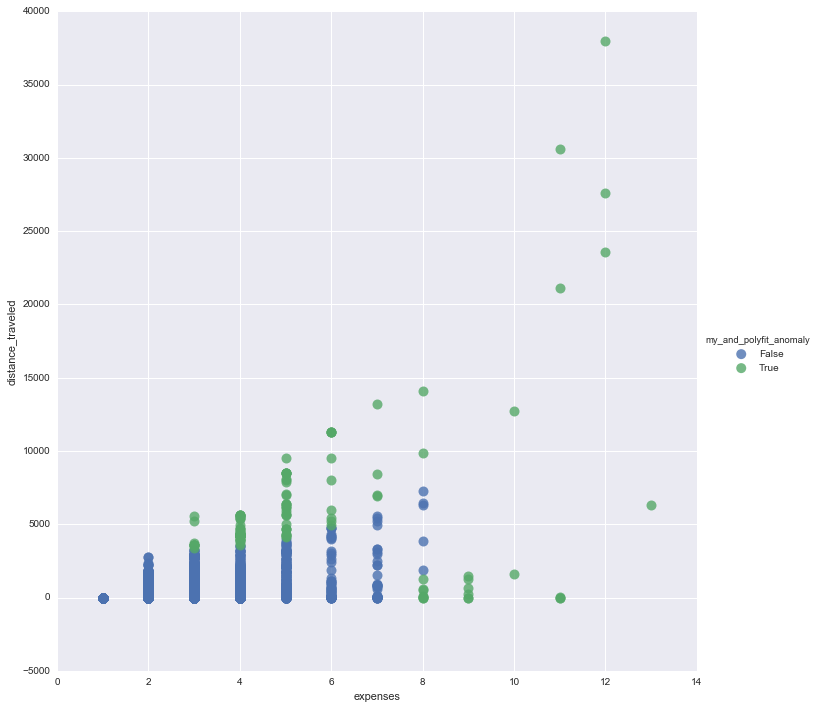

In [134]:
sns.lmplot('expenses', 'distance_traveled',
           data=dataset_with_distances,
           hue='my_and_polyfit_anomaly',
           scatter_kws={'marker': 'D',
                        's': 100},
           fit_reg=False,
           size=10)

In [135]:
dataset_with_distances.query('my_and_polyfit_anomaly & (expenses == 3)')

,congressperson_name,issue_date,sum,mean,expenses,city_list,city,distance_traveled,3_stds_anomaly,5_stds_anomaly,isolation_forest_anomaly,lof_anomaly,lof_and_5_stds,lof_or_5_stds,my_anomaly,my_and_forest_anomaly,expected_distance,polyfit_anomaly,my_and_polyfit_anomaly
19028,CARLOS MAGNO,2013-10-10,280.00,93.333333,3,"PORTO VELHO,BRASILIA",2,3566.296003,False,False,False,False,False,False,False,False,287.896887,True,True
70051,LEO DE BRITO,2015-10-22,216.42,72.140000,3,"CRUZEIRO DO SUL,BRASILIA",2,5527.980572,False,False,False,False,False,False,False,False,287.896887,True,True
81607,MARCOS ROGÉRIO,2012-01-25,67.25,22.416667,3,"PORTO VELHO,ARIQUEMES,BRASILIA",3,3560.254307,False,False,False,False,False,False,False,False,287.896887,True,True
81820,MARCOS ROGÉRIO,2013-04-13,173.25,57.750000,3,"JI-PARANA,PORTO VELHO,BRASILIA",3,3558.943935,False,False,False,False,False,False,False,False,287.896887,True,True
81926,MARCOS ROGÉRIO,2013-10-14,243.10,81.033333,3,"VITORIA,PORTO VELHO,BRASILIA",3,5252.271051,False,False,False,False,False,False,False,False,287.896887,True,True
82101,MARCOS ROGÉRIO,2014-11-06,164.21,54.736667,3,"PORTO VELHO,BRASILIA",2,3564.912654,False,False,False,False,False,False,False,False,287.896887,True,True
93652,PADRE TON,2011-04-14,121.03,40.343333,3,"OURO PRETO DO OESTE,PORTO VELHO,BRASILIA",3,3562.966130,False,False,False,False,False,False,False,False,287.896887,True,True
93726,PADRE TON,2012-03-30,84.69,28.230000,3,"OURO PRETO DO OESTE,ARIQUEMES,BRASILIA",3,3361.694879,False,False,False,False,False,False,False,False,287.896887,True,True
105984,ROCHA,2015-06-19,243.00,81.000000,3,"CAXIAS DO SUL,RIO BRANCO",2,3712.992646,False,False,False,False,False,False,False,False,287.896887,True,True


In [136]:
dataset.query('(congressperson_name == "ROCHA") & (issue_date == "2015-06-19")')['document_id'].values

array([5736263, 5717874, 5717827])

In [137]:
dataset_with_distances.query('my_and_polyfit_anomaly') \
    .groupby('congressperson_name')['expenses'].count().reset_index() \
    .rename(columns={'expenses': 'abnormal_days'}) \
    .sort_values('abnormal_days', ascending=False) \
    .head(10)

,congressperson_name,abnormal_days
25,SANDRA ROSADO,55
10,FRANCISCO DE ASSIS,9
13,JORGE SOLLA,8
21,PAULO WAGNER,7
17,MARCOS ROGÉRIO,7
31,ZECA DIRCEU,5
3,ANTÔNIO JÁCOME,3
19,PADRE TON,2
18,MARINALDO ROSENDO,2
1,AELTON FREITAS,2


In [138]:
dataset_with_distances.query('my_and_polyfit_anomaly')['expenses'].sum()

703

In [139]:
dataset_with_distances.query('my_and_polyfit_anomaly')['sum'].sum()

28752.989999999998

## Conclusions

The results from "polyfit anomaly" don't necessarily mean anomalies, neither the final approach can really be consider a Anomaly Detection method. Yet is able to alert about a few cases deserving auditing and further investigation to prove illegal or immoral activities:

1. Days with too many meal reimbursements/expenses. More than 8 meal reimbursuments in a single day is too suspicious.
2. Days with a large number of meal reimbursements without a travel to explain.
3. Days where the traveled distance is so big that it's suspicious by itself.

---

[Ana Schwendler](https://github.com/anaschwendler) was my pair during a good portion of the time working on this analysis. [Felipe Cabral](https://github.com/cabral) also gave a nice guidance helping to define anomalous expenses and brainstorming approaches.